## 사용할 라이브러리

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models1')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

슝=3


## json 파싱하기

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
#     print(json_formatted_str)

##  json annotation 을 파싱하는 함수

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

슝=3


## parse_one_annotation()함수를 테스트

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


## TFrecord

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

슝=3


## 얼마나 많은 TFRecord를 만들지 결정할 함수

In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

슝=3


## chunkify함수를 테스트

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

## chunk를 TFRecord로 만들어 줄 함수

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

슝=3


## 전체 데이터를 적당한 수의 TFRecord 파일로 만들어주는 함수

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

슝=3


##  데이터를 TFRecord로 만들어 줍니다

In [10]:
# num_train_shards = 64
# num_val_shards = 8

# ray.init()

# print('Start to parse annotations.')
# if not os.path.exists(TFRECORD_PATH):
#     os.makedirs(TFRECORD_PATH)

# with open(TRAIN_JSON) as train_json:
#     train_annos = json.load(train_json)
#     train_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH)
#         for anno in train_annos
#     ]
#     print('First train annotation: ', train_annotations[0])

# with open(VALID_JSON) as val_json:
#     val_annos = json.load(val_json)
#     val_annotations = [
#         parse_one_annotation(anno, IMAGE_PATH) 
#         for anno in val_annos
#     ]
#     print('First val annotation: ', val_annotations[0])
    
# print('Start to build TF Records.')
# build_tf_records(train_annotations, num_train_shards, 'train')
# build_tf_records(val_annotations, num_val_shards, 'val')

# print('Successfully wrote {} annotations to TF Records.'.format(
#     len(train_annotations) + len(val_annotations)))

## TFRecord로 저장된 데이터를 모델에 학습에 필요한 데이터로 바꿔줄 함수

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

슝=3


## 이렇게 얻은 image 와 label 을 이용해서 적절한 학습 형태로 변환합니다. 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop하여 사용합니다.

우리가 알고 있는 것은 joints 의 위치, center 의 좌표, body height 값입니다. 균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요합니다. 이와 관련해서는 여러 방법이 있을 수 있겠지만 배우는 단계에서 더 중요하게 봐야 할 부분은 우리가 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다는 점입니다.



In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

슝=3


## 확률 분포로는 2차원 가우시안 분포를 사용합니다.

In [13]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

슝=3


## 지금까지 만든 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합해 볼게요. 

In [14]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

슝=3


## Hourglass 모델 만들기

In [15]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

print('슝=3')

슝=3


In [16]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

print('슝=3')

슝=3


In [17]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

print('슝=3')

슝=3


## 지금까지 만든 hourglass 를 여러 층으로 쌓으면 stacked hourglass 가 됩니다.

In [18]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

print('슝=3')

슝=3


## samplebaseline 모델

In [19]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model




def Simplebaseline(input_shape=(256, 256, 3)):
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    upconv = _make_deconv_layer(3)
    final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')
    inputs = keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)
    model = tf.keras.Model(inputs, out, name='simple_baseline')
  
    return model

## GPU가 여러 개인 환경

In [20]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            # print(f'오류 출력 부 입니다. 가중치 : {weights},loss : {tf.math.square(labels - output) * weights}')
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
            

        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)
            # print(f'computeloss출력값 입니다.: {loss}\타입:{type(loss)}')

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/{}-epoch-{}-loss-{:.4f}.h5'.format(self.model.name,epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

print('슝=3')

슝=3


## 데이터 셋

In [21]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

슝=3


In [22]:
def train(model_name, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
        if model_name == 'hourglass':
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        else:
            model = Simplebaseline(IMAGE_SHAPE)
        
        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
#         print(f'출력 확인용 {train_dist_dataset},{val_dist_dataset}')
#         print('출력확인용----------------------------------------------------------------------------------------------------')
        return trainer.run(train_dist_dataset, val_dist_dataset)

print('슝=3')

슝=3


## StackedHourglassNetwork 모델학습

In [23]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train('hourglass' ,epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

# 예측 엔진 만들기

# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models1', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.67813969 epoch total loss 2.67813969
Trained batch 2 batch loss 2.50067186 epoch total loss 2.58940578
Trained batch 3 batch loss 2.47201014 epoch total loss 2.5502739
Trained batch 4 batch loss 2.40473533 epoch total loss 2.51388931
Trained batch 5 batch loss 2.23392 epoch total loss 2.45789552
Trained batch 6 batch loss 2.25848389 epoch total loss 2.42466021
Trained batch 7 batch loss 2.20072985 epoch total loss 2.39267015
Trained batch 8 batch loss 2.11750937 epoch total loss 2.35827518
Trained batch 9 batch loss 2.0728817 epoch total loss 2.32656479
Trained batch 10 batch loss 2.05813718 epoch total loss 2.29972219
Trained batch 11 batch loss 2.01598263 epoch total loss 2.27392745
Trained batch 12 batch loss 2.00051308 epoch total loss 2.25114298
Trained batch 13 batch loss 2.02146602 epoch total loss 2.23347545
Trained batch 14 batch loss 1.9406116 epoch total loss 2.2125566
Trained batch 15 batch loss 1.97110319 epoch to

Trained batch 124 batch loss 1.58649802 epoch total loss 1.79071581
Trained batch 125 batch loss 1.65689039 epoch total loss 1.78964531
Trained batch 126 batch loss 1.7111237 epoch total loss 1.78902209
Trained batch 127 batch loss 1.59336448 epoch total loss 1.78748143
Trained batch 128 batch loss 1.72284889 epoch total loss 1.78697658
Trained batch 129 batch loss 1.8289088 epoch total loss 1.78730154
Trained batch 130 batch loss 1.80223513 epoch total loss 1.78741646
Trained batch 131 batch loss 1.73032904 epoch total loss 1.78698063
Trained batch 132 batch loss 1.57320297 epoch total loss 1.78536105
Trained batch 133 batch loss 1.6834445 epoch total loss 1.78459477
Trained batch 134 batch loss 1.55167341 epoch total loss 1.78285646
Trained batch 135 batch loss 1.71289825 epoch total loss 1.78233826
Trained batch 136 batch loss 1.73194528 epoch total loss 1.78196776
Trained batch 137 batch loss 1.7610575 epoch total loss 1.78181517
Trained batch 138 batch loss 1.71946394 epoch total 

Trained batch 245 batch loss 1.60906947 epoch total loss 1.72077823
Trained batch 246 batch loss 1.57220376 epoch total loss 1.72017431
Trained batch 247 batch loss 1.68672645 epoch total loss 1.72003889
Trained batch 248 batch loss 1.57828903 epoch total loss 1.71946728
Trained batch 249 batch loss 1.61731219 epoch total loss 1.71905696
Trained batch 250 batch loss 1.55957532 epoch total loss 1.71841908
Trained batch 251 batch loss 1.50781119 epoch total loss 1.71758
Trained batch 252 batch loss 1.56393313 epoch total loss 1.71697032
Trained batch 253 batch loss 1.50760508 epoch total loss 1.71614277
Trained batch 254 batch loss 1.59319925 epoch total loss 1.71565866
Trained batch 255 batch loss 1.66036749 epoch total loss 1.71544194
Trained batch 256 batch loss 1.73453069 epoch total loss 1.71551645
Trained batch 257 batch loss 1.59287596 epoch total loss 1.71503925
Trained batch 258 batch loss 1.58290493 epoch total loss 1.71452713
Trained batch 259 batch loss 1.45760214 epoch total

Trained batch 367 batch loss 1.61669695 epoch total loss 1.67994094
Trained batch 368 batch loss 1.42198682 epoch total loss 1.67924
Trained batch 369 batch loss 1.36734426 epoch total loss 1.67839479
Trained batch 370 batch loss 1.62919784 epoch total loss 1.67826188
Trained batch 371 batch loss 1.66391087 epoch total loss 1.67822337
Trained batch 372 batch loss 1.52364373 epoch total loss 1.67780769
Trained batch 373 batch loss 1.63295603 epoch total loss 1.67768741
Trained batch 374 batch loss 1.55836368 epoch total loss 1.67736828
Trained batch 375 batch loss 1.66024876 epoch total loss 1.67732275
Trained batch 376 batch loss 1.54710603 epoch total loss 1.67697644
Trained batch 377 batch loss 1.61202085 epoch total loss 1.67680407
Trained batch 378 batch loss 1.62321281 epoch total loss 1.67666233
Trained batch 379 batch loss 1.491431 epoch total loss 1.67617369
Trained batch 380 batch loss 1.48141062 epoch total loss 1.67566109
Trained batch 381 batch loss 1.60450232 epoch total l

Trained batch 488 batch loss 1.51561069 epoch total loss 1.65115583
Trained batch 489 batch loss 1.61517191 epoch total loss 1.65108228
Trained batch 490 batch loss 1.64377892 epoch total loss 1.65106738
Trained batch 491 batch loss 1.56653595 epoch total loss 1.65089524
Trained batch 492 batch loss 1.52309537 epoch total loss 1.65063536
Trained batch 493 batch loss 1.57587457 epoch total loss 1.65048373
Trained batch 494 batch loss 1.59388125 epoch total loss 1.65036917
Trained batch 495 batch loss 1.47957444 epoch total loss 1.65002406
Trained batch 496 batch loss 1.53322637 epoch total loss 1.6497885
Trained batch 497 batch loss 1.48887372 epoch total loss 1.64946473
Trained batch 498 batch loss 1.61989212 epoch total loss 1.64940536
Trained batch 499 batch loss 1.59402132 epoch total loss 1.64929426
Trained batch 500 batch loss 1.53602087 epoch total loss 1.64906776
Trained batch 501 batch loss 1.57188272 epoch total loss 1.64891374
Trained batch 502 batch loss 1.50455916 epoch tot

Trained batch 610 batch loss 1.46869159 epoch total loss 1.62722564
Trained batch 611 batch loss 1.48353696 epoch total loss 1.62699044
Trained batch 612 batch loss 1.48725724 epoch total loss 1.62676215
Trained batch 613 batch loss 1.46423805 epoch total loss 1.62649703
Trained batch 614 batch loss 1.57093203 epoch total loss 1.62640655
Trained batch 615 batch loss 1.30171835 epoch total loss 1.62587845
Trained batch 616 batch loss 1.36046958 epoch total loss 1.62544763
Trained batch 617 batch loss 1.18071294 epoch total loss 1.62472689
Trained batch 618 batch loss 1.41278183 epoch total loss 1.62438393
Trained batch 619 batch loss 1.53936112 epoch total loss 1.6242466
Trained batch 620 batch loss 1.64424062 epoch total loss 1.62427878
Trained batch 621 batch loss 1.60548306 epoch total loss 1.6242485
Trained batch 622 batch loss 1.52357602 epoch total loss 1.62408662
Trained batch 623 batch loss 1.49723506 epoch total loss 1.62388301
Trained batch 624 batch loss 1.4668721 epoch total

Trained batch 731 batch loss 1.3275485 epoch total loss 1.60537446
Trained batch 732 batch loss 1.36449337 epoch total loss 1.60504532
Trained batch 733 batch loss 1.53801477 epoch total loss 1.60495377
Trained batch 734 batch loss 1.56136608 epoch total loss 1.60489452
Trained batch 735 batch loss 1.59506428 epoch total loss 1.60488117
Trained batch 736 batch loss 1.61316454 epoch total loss 1.60489237
Trained batch 737 batch loss 1.58485794 epoch total loss 1.60486519
Trained batch 738 batch loss 1.47954607 epoch total loss 1.60469532
Trained batch 739 batch loss 1.47561288 epoch total loss 1.60452056
Trained batch 740 batch loss 1.45080447 epoch total loss 1.6043129
Trained batch 741 batch loss 1.58921802 epoch total loss 1.60429251
Trained batch 742 batch loss 1.38732088 epoch total loss 1.60400009
Trained batch 743 batch loss 1.47344363 epoch total loss 1.60382438
Trained batch 744 batch loss 1.36645389 epoch total loss 1.60350525
Trained batch 745 batch loss 1.51016402 epoch tota

Trained batch 852 batch loss 1.52855229 epoch total loss 1.58803797
Trained batch 853 batch loss 1.55135536 epoch total loss 1.58799493
Trained batch 854 batch loss 1.61886013 epoch total loss 1.58803117
Trained batch 855 batch loss 1.54334271 epoch total loss 1.58797884
Trained batch 856 batch loss 1.48277509 epoch total loss 1.58785594
Trained batch 857 batch loss 1.50140917 epoch total loss 1.5877552
Trained batch 858 batch loss 1.47407472 epoch total loss 1.58762276
Trained batch 859 batch loss 1.5054884 epoch total loss 1.58752716
Trained batch 860 batch loss 1.52118587 epoch total loss 1.58745
Trained batch 861 batch loss 1.41027331 epoch total loss 1.58724427
Trained batch 862 batch loss 1.50469184 epoch total loss 1.58714843
Trained batch 863 batch loss 1.50904655 epoch total loss 1.58705795
Trained batch 864 batch loss 1.49081862 epoch total loss 1.58694661
Trained batch 865 batch loss 1.48384464 epoch total loss 1.5868274
Trained batch 866 batch loss 1.55724728 epoch total lo

Trained batch 974 batch loss 1.51449168 epoch total loss 1.57538009
Trained batch 975 batch loss 1.55261612 epoch total loss 1.57535672
Trained batch 976 batch loss 1.50755334 epoch total loss 1.57528722
Trained batch 977 batch loss 1.63676465 epoch total loss 1.57535017
Trained batch 978 batch loss 1.44497085 epoch total loss 1.57521677
Trained batch 979 batch loss 1.47615409 epoch total loss 1.57511568
Trained batch 980 batch loss 1.41122 epoch total loss 1.57494843
Trained batch 981 batch loss 1.51492476 epoch total loss 1.57488716
Trained batch 982 batch loss 1.46441984 epoch total loss 1.57477474
Trained batch 983 batch loss 1.48081279 epoch total loss 1.57467926
Trained batch 984 batch loss 1.40828538 epoch total loss 1.5745101
Trained batch 985 batch loss 1.40411294 epoch total loss 1.57433712
Trained batch 986 batch loss 1.51747537 epoch total loss 1.57427943
Trained batch 987 batch loss 1.46662211 epoch total loss 1.57417035
Trained batch 988 batch loss 1.46465564 epoch total 

Trained batch 1094 batch loss 1.44899631 epoch total loss 1.56688178
Trained batch 1095 batch loss 1.50962532 epoch total loss 1.56682956
Trained batch 1096 batch loss 1.52914333 epoch total loss 1.56679523
Trained batch 1097 batch loss 1.55421972 epoch total loss 1.56678367
Trained batch 1098 batch loss 1.56543648 epoch total loss 1.56678247
Trained batch 1099 batch loss 1.59846628 epoch total loss 1.56681132
Trained batch 1100 batch loss 1.49627709 epoch total loss 1.56674731
Trained batch 1101 batch loss 1.42595816 epoch total loss 1.5666194
Trained batch 1102 batch loss 1.46146452 epoch total loss 1.56652391
Trained batch 1103 batch loss 1.41524231 epoch total loss 1.56638682
Trained batch 1104 batch loss 1.46903682 epoch total loss 1.5662986
Trained batch 1105 batch loss 1.4323864 epoch total loss 1.56617737
Trained batch 1106 batch loss 1.35705328 epoch total loss 1.5659883
Trained batch 1107 batch loss 1.44730139 epoch total loss 1.56588101
Trained batch 1108 batch loss 1.433479

Trained batch 1214 batch loss 1.30572939 epoch total loss 1.55796409
Trained batch 1215 batch loss 1.45946205 epoch total loss 1.55788302
Trained batch 1216 batch loss 1.38232458 epoch total loss 1.55773866
Trained batch 1217 batch loss 1.40081382 epoch total loss 1.55760968
Trained batch 1218 batch loss 1.56881261 epoch total loss 1.55761886
Trained batch 1219 batch loss 1.47549117 epoch total loss 1.5575515
Trained batch 1220 batch loss 1.26182842 epoch total loss 1.55730915
Trained batch 1221 batch loss 1.35918593 epoch total loss 1.55714679
Trained batch 1222 batch loss 1.33649862 epoch total loss 1.5569663
Trained batch 1223 batch loss 1.37058544 epoch total loss 1.55681396
Trained batch 1224 batch loss 1.41757166 epoch total loss 1.55670011
Trained batch 1225 batch loss 1.47346652 epoch total loss 1.55663228
Trained batch 1226 batch loss 1.50259757 epoch total loss 1.55658817
Trained batch 1227 batch loss 1.32491469 epoch total loss 1.55639935
Trained batch 1228 batch loss 1.3764

Trained batch 1334 batch loss 1.39069009 epoch total loss 1.54654944
Trained batch 1335 batch loss 1.45990562 epoch total loss 1.54648459
Trained batch 1336 batch loss 1.52888715 epoch total loss 1.54647136
Trained batch 1337 batch loss 1.48497367 epoch total loss 1.54642522
Trained batch 1338 batch loss 1.50335562 epoch total loss 1.54639316
Trained batch 1339 batch loss 1.48643851 epoch total loss 1.54634821
Trained batch 1340 batch loss 1.59564137 epoch total loss 1.54638505
Trained batch 1341 batch loss 1.56142974 epoch total loss 1.54639637
Trained batch 1342 batch loss 1.49587929 epoch total loss 1.5463587
Trained batch 1343 batch loss 1.51131094 epoch total loss 1.5463326
Trained batch 1344 batch loss 1.49713731 epoch total loss 1.54629588
Trained batch 1345 batch loss 1.42618477 epoch total loss 1.54620671
Trained batch 1346 batch loss 1.53596795 epoch total loss 1.54619896
Trained batch 1347 batch loss 1.39742935 epoch total loss 1.54608858
Trained batch 1348 batch loss 1.3641

Validated batch 109 batch loss 1.42926371
Validated batch 110 batch loss 1.4182663
Validated batch 111 batch loss 1.43840885
Validated batch 112 batch loss 1.50936687
Validated batch 113 batch loss 1.44479895
Validated batch 114 batch loss 1.46641803
Validated batch 115 batch loss 1.33080864
Validated batch 116 batch loss 1.50526345
Validated batch 117 batch loss 1.41096413
Validated batch 118 batch loss 1.42711294
Validated batch 119 batch loss 1.41795063
Validated batch 120 batch loss 1.36872983
Validated batch 121 batch loss 1.45580125
Validated batch 122 batch loss 1.41814208
Validated batch 123 batch loss 1.37166417
Validated batch 124 batch loss 1.38893473
Validated batch 125 batch loss 1.40136993
Validated batch 126 batch loss 1.45405173
Validated batch 127 batch loss 1.44656599
Validated batch 128 batch loss 1.41670179
Validated batch 129 batch loss 1.34504247
Validated batch 130 batch loss 1.39414406
Validated batch 131 batch loss 1.44047546
Validated batch 132 batch loss 1.43

Trained batch 73 batch loss 1.43518555 epoch total loss 1.43322
Trained batch 74 batch loss 1.34939075 epoch total loss 1.43208718
Trained batch 75 batch loss 1.37153077 epoch total loss 1.43127966
Trained batch 76 batch loss 1.32358623 epoch total loss 1.42986262
Trained batch 77 batch loss 1.34874594 epoch total loss 1.42880929
Trained batch 78 batch loss 1.32923257 epoch total loss 1.42753255
Trained batch 79 batch loss 1.41440344 epoch total loss 1.42736638
Trained batch 80 batch loss 1.40091777 epoch total loss 1.42703581
Trained batch 81 batch loss 1.29051387 epoch total loss 1.42535031
Trained batch 82 batch loss 1.27506864 epoch total loss 1.4235177
Trained batch 83 batch loss 1.37422955 epoch total loss 1.4229238
Trained batch 84 batch loss 1.45145047 epoch total loss 1.42326343
Trained batch 85 batch loss 1.355492 epoch total loss 1.42246616
Trained batch 86 batch loss 1.33707309 epoch total loss 1.42147326
Trained batch 87 batch loss 1.29748166 epoch total loss 1.42004812
Tr

Trained batch 195 batch loss 1.44014931 epoch total loss 1.41161191
Trained batch 196 batch loss 1.33343101 epoch total loss 1.41121304
Trained batch 197 batch loss 1.43468487 epoch total loss 1.41133213
Trained batch 198 batch loss 1.47261667 epoch total loss 1.41164172
Trained batch 199 batch loss 1.40260828 epoch total loss 1.41159642
Trained batch 200 batch loss 1.55510461 epoch total loss 1.41231394
Trained batch 201 batch loss 1.48578238 epoch total loss 1.41267943
Trained batch 202 batch loss 1.41751754 epoch total loss 1.41270339
Trained batch 203 batch loss 1.35618615 epoch total loss 1.41242504
Trained batch 204 batch loss 1.36432409 epoch total loss 1.41218925
Trained batch 205 batch loss 1.37025023 epoch total loss 1.41198468
Trained batch 206 batch loss 1.43452823 epoch total loss 1.41209412
Trained batch 207 batch loss 1.46221721 epoch total loss 1.41233623
Trained batch 208 batch loss 1.39032865 epoch total loss 1.41223037
Trained batch 209 batch loss 1.53356075 epoch to

Trained batch 316 batch loss 1.43704426 epoch total loss 1.41004825
Trained batch 317 batch loss 1.44067323 epoch total loss 1.41014493
Trained batch 318 batch loss 1.29212105 epoch total loss 1.40977371
Trained batch 319 batch loss 1.34624863 epoch total loss 1.40957463
Trained batch 320 batch loss 1.25792265 epoch total loss 1.40910077
Trained batch 321 batch loss 1.3147 epoch total loss 1.40880668
Trained batch 322 batch loss 1.33936894 epoch total loss 1.40859091
Trained batch 323 batch loss 1.304075 epoch total loss 1.40826738
Trained batch 324 batch loss 1.22053039 epoch total loss 1.4076879
Trained batch 325 batch loss 1.29489541 epoch total loss 1.40734088
Trained batch 326 batch loss 1.53395128 epoch total loss 1.40772927
Trained batch 327 batch loss 1.32044256 epoch total loss 1.40746236
Trained batch 328 batch loss 1.25715554 epoch total loss 1.407004
Trained batch 329 batch loss 1.26486504 epoch total loss 1.40657198
Trained batch 330 batch loss 1.2606051 epoch total loss 1

Trained batch 438 batch loss 1.40718269 epoch total loss 1.40178978
Trained batch 439 batch loss 1.40466511 epoch total loss 1.40179634
Trained batch 440 batch loss 1.51076579 epoch total loss 1.40204394
Trained batch 441 batch loss 1.4368881 epoch total loss 1.40212297
Trained batch 442 batch loss 1.49743342 epoch total loss 1.40233862
Trained batch 443 batch loss 1.55692887 epoch total loss 1.40268767
Trained batch 444 batch loss 1.49054599 epoch total loss 1.40288556
Trained batch 445 batch loss 1.3621012 epoch total loss 1.40279388
Trained batch 446 batch loss 1.37552536 epoch total loss 1.40273285
Trained batch 447 batch loss 1.38824129 epoch total loss 1.40270042
Trained batch 448 batch loss 1.41861916 epoch total loss 1.40273595
Trained batch 449 batch loss 1.39828598 epoch total loss 1.40272617
Trained batch 450 batch loss 1.31541562 epoch total loss 1.4025321
Trained batch 451 batch loss 1.29567432 epoch total loss 1.40229511
Trained batch 452 batch loss 1.35566413 epoch total

Trained batch 560 batch loss 1.36510921 epoch total loss 1.39598954
Trained batch 561 batch loss 1.34932828 epoch total loss 1.39590633
Trained batch 562 batch loss 1.40518165 epoch total loss 1.39592278
Trained batch 563 batch loss 1.40636659 epoch total loss 1.39594138
Trained batch 564 batch loss 1.42274284 epoch total loss 1.39598882
Trained batch 565 batch loss 1.28381586 epoch total loss 1.39579034
Trained batch 566 batch loss 1.39934516 epoch total loss 1.39579666
Trained batch 567 batch loss 1.4488939 epoch total loss 1.39589024
Trained batch 568 batch loss 1.27292764 epoch total loss 1.39567387
Trained batch 569 batch loss 1.37936568 epoch total loss 1.39564526
Trained batch 570 batch loss 1.41540456 epoch total loss 1.39567983
Trained batch 571 batch loss 1.36176825 epoch total loss 1.39562047
Trained batch 572 batch loss 1.3919816 epoch total loss 1.39561415
Trained batch 573 batch loss 1.28987598 epoch total loss 1.39542949
Trained batch 574 batch loss 1.16628015 epoch tota

Trained batch 681 batch loss 1.39048815 epoch total loss 1.39236212
Trained batch 682 batch loss 1.51648521 epoch total loss 1.39254415
Trained batch 683 batch loss 1.35893989 epoch total loss 1.39249492
Trained batch 684 batch loss 1.35201192 epoch total loss 1.39243567
Trained batch 685 batch loss 1.43437707 epoch total loss 1.39249694
Trained batch 686 batch loss 1.33765948 epoch total loss 1.39241695
Trained batch 687 batch loss 1.33641279 epoch total loss 1.39233553
Trained batch 688 batch loss 1.33396602 epoch total loss 1.39225066
Trained batch 689 batch loss 1.38329673 epoch total loss 1.39223766
Trained batch 690 batch loss 1.22862482 epoch total loss 1.39200056
Trained batch 691 batch loss 1.31179714 epoch total loss 1.39188445
Trained batch 692 batch loss 1.24556279 epoch total loss 1.39167297
Trained batch 693 batch loss 1.39979577 epoch total loss 1.39168465
Trained batch 694 batch loss 1.56216443 epoch total loss 1.39193034
Trained batch 695 batch loss 1.51817644 epoch to

Trained batch 802 batch loss 1.39300847 epoch total loss 1.39062715
Trained batch 803 batch loss 1.55514097 epoch total loss 1.39083207
Trained batch 804 batch loss 1.63786483 epoch total loss 1.39113927
Trained batch 805 batch loss 1.41788983 epoch total loss 1.39117241
Trained batch 806 batch loss 1.2672267 epoch total loss 1.39101863
Trained batch 807 batch loss 1.26524067 epoch total loss 1.39086282
Trained batch 808 batch loss 1.33578312 epoch total loss 1.39079463
Trained batch 809 batch loss 1.42139494 epoch total loss 1.39083242
Trained batch 810 batch loss 1.32731164 epoch total loss 1.39075398
Trained batch 811 batch loss 1.37633502 epoch total loss 1.39073622
Trained batch 812 batch loss 1.4215982 epoch total loss 1.39077425
Trained batch 813 batch loss 1.44129312 epoch total loss 1.39083636
Trained batch 814 batch loss 1.49513555 epoch total loss 1.39096451
Trained batch 815 batch loss 1.36676669 epoch total loss 1.39093494
Trained batch 816 batch loss 1.37712836 epoch tota

Trained batch 923 batch loss 1.21939218 epoch total loss 1.38357496
Trained batch 924 batch loss 1.3374486 epoch total loss 1.38352501
Trained batch 925 batch loss 1.41312921 epoch total loss 1.38355696
Trained batch 926 batch loss 1.33759761 epoch total loss 1.38350737
Trained batch 927 batch loss 1.51712596 epoch total loss 1.38365149
Trained batch 928 batch loss 1.39360619 epoch total loss 1.3836621
Trained batch 929 batch loss 1.33596587 epoch total loss 1.38361073
Trained batch 930 batch loss 1.38056707 epoch total loss 1.38360751
Trained batch 931 batch loss 1.34908259 epoch total loss 1.38357043
Trained batch 932 batch loss 1.38322616 epoch total loss 1.38357008
Trained batch 933 batch loss 1.4165206 epoch total loss 1.38360536
Trained batch 934 batch loss 1.34134197 epoch total loss 1.38356006
Trained batch 935 batch loss 1.35551608 epoch total loss 1.38353
Trained batch 936 batch loss 1.33500445 epoch total loss 1.38347816
Trained batch 937 batch loss 1.26330137 epoch total lo

Trained batch 1044 batch loss 1.35784841 epoch total loss 1.37818742
Trained batch 1045 batch loss 1.4756397 epoch total loss 1.37828064
Trained batch 1046 batch loss 1.36441755 epoch total loss 1.37826729
Trained batch 1047 batch loss 1.24379671 epoch total loss 1.3781389
Trained batch 1048 batch loss 1.26674342 epoch total loss 1.37803257
Trained batch 1049 batch loss 1.27442598 epoch total loss 1.37793374
Trained batch 1050 batch loss 1.25933504 epoch total loss 1.37782073
Trained batch 1051 batch loss 1.25427103 epoch total loss 1.37770319
Trained batch 1052 batch loss 1.30393863 epoch total loss 1.37763309
Trained batch 1053 batch loss 1.20001149 epoch total loss 1.37746441
Trained batch 1054 batch loss 1.27995622 epoch total loss 1.37737179
Trained batch 1055 batch loss 1.25618494 epoch total loss 1.37725699
Trained batch 1056 batch loss 1.27440047 epoch total loss 1.3771596
Trained batch 1057 batch loss 1.30188096 epoch total loss 1.37708831
Trained batch 1058 batch loss 1.28655

Trained batch 1164 batch loss 1.2504847 epoch total loss 1.37156057
Trained batch 1165 batch loss 1.40696776 epoch total loss 1.37159097
Trained batch 1166 batch loss 1.41511881 epoch total loss 1.37162828
Trained batch 1167 batch loss 1.17477798 epoch total loss 1.3714596
Trained batch 1168 batch loss 1.22667348 epoch total loss 1.37133574
Trained batch 1169 batch loss 1.16405773 epoch total loss 1.37115836
Trained batch 1170 batch loss 1.15983033 epoch total loss 1.37097776
Trained batch 1171 batch loss 1.20984197 epoch total loss 1.37084007
Trained batch 1172 batch loss 1.3087132 epoch total loss 1.37078714
Trained batch 1173 batch loss 1.30397177 epoch total loss 1.37073016
Trained batch 1174 batch loss 1.24560106 epoch total loss 1.37062359
Trained batch 1175 batch loss 1.26914322 epoch total loss 1.37053716
Trained batch 1176 batch loss 1.2502588 epoch total loss 1.37043488
Trained batch 1177 batch loss 1.32917118 epoch total loss 1.3704
Trained batch 1178 batch loss 1.30861843 e

Trained batch 1284 batch loss 1.30924129 epoch total loss 1.36717105
Trained batch 1285 batch loss 1.35538936 epoch total loss 1.36716187
Trained batch 1286 batch loss 1.28292406 epoch total loss 1.36709642
Trained batch 1287 batch loss 1.37270248 epoch total loss 1.36710072
Trained batch 1288 batch loss 1.35097587 epoch total loss 1.3670882
Trained batch 1289 batch loss 1.49486387 epoch total loss 1.36718726
Trained batch 1290 batch loss 1.38640928 epoch total loss 1.36720216
Trained batch 1291 batch loss 1.41876531 epoch total loss 1.3672421
Trained batch 1292 batch loss 1.39003801 epoch total loss 1.36725974
Trained batch 1293 batch loss 1.25241435 epoch total loss 1.36717093
Trained batch 1294 batch loss 1.39592063 epoch total loss 1.3671931
Trained batch 1295 batch loss 1.20746601 epoch total loss 1.36706984
Trained batch 1296 batch loss 1.3351202 epoch total loss 1.36704516
Trained batch 1297 batch loss 1.29056382 epoch total loss 1.36698616
Trained batch 1298 batch loss 1.358646

Validated batch 25 batch loss 1.19515431
Validated batch 26 batch loss 1.31442654
Validated batch 27 batch loss 1.23869753
Validated batch 28 batch loss 1.29403949
Validated batch 29 batch loss 1.35357833
Validated batch 30 batch loss 1.30319297
Validated batch 31 batch loss 1.44745111
Validated batch 32 batch loss 1.38436723
Validated batch 33 batch loss 1.32149732
Validated batch 34 batch loss 1.30889535
Validated batch 35 batch loss 1.4050132
Validated batch 36 batch loss 1.40803766
Validated batch 37 batch loss 1.38507462
Validated batch 38 batch loss 1.35288572
Validated batch 39 batch loss 1.38072681
Validated batch 40 batch loss 1.36917067
Validated batch 41 batch loss 1.19945598
Validated batch 42 batch loss 1.29317129
Validated batch 43 batch loss 1.34352469
Validated batch 44 batch loss 1.33897579
Validated batch 45 batch loss 1.33200538
Validated batch 46 batch loss 1.29866862
Validated batch 47 batch loss 1.29113412
Validated batch 48 batch loss 1.29667377
Validated batch 4

Trained batch 22 batch loss 1.25738406 epoch total loss 1.31120217
Trained batch 23 batch loss 1.22474718 epoch total loss 1.30744326
Trained batch 24 batch loss 1.1529367 epoch total loss 1.30100548
Trained batch 25 batch loss 1.16026521 epoch total loss 1.29537594
Trained batch 26 batch loss 1.37142777 epoch total loss 1.2983011
Trained batch 27 batch loss 1.37928772 epoch total loss 1.30130064
Trained batch 28 batch loss 1.32088161 epoch total loss 1.30199993
Trained batch 29 batch loss 1.29089785 epoch total loss 1.30161703
Trained batch 30 batch loss 1.35418844 epoch total loss 1.3033694
Trained batch 31 batch loss 1.37468338 epoch total loss 1.3056699
Trained batch 32 batch loss 1.42329311 epoch total loss 1.3093456
Trained batch 33 batch loss 1.30289972 epoch total loss 1.30915022
Trained batch 34 batch loss 1.32310486 epoch total loss 1.30956066
Trained batch 35 batch loss 1.2577579 epoch total loss 1.30808067
Trained batch 36 batch loss 1.28653383 epoch total loss 1.30748212
T

Trained batch 145 batch loss 1.29411101 epoch total loss 1.29728007
Trained batch 146 batch loss 1.31023371 epoch total loss 1.29736876
Trained batch 147 batch loss 1.17674327 epoch total loss 1.29654813
Trained batch 148 batch loss 1.30740094 epoch total loss 1.29662144
Trained batch 149 batch loss 1.27170444 epoch total loss 1.29645419
Trained batch 150 batch loss 1.25497675 epoch total loss 1.29617763
Trained batch 151 batch loss 1.23673463 epoch total loss 1.295784
Trained batch 152 batch loss 1.17828691 epoch total loss 1.29501104
Trained batch 153 batch loss 1.34456515 epoch total loss 1.29533482
Trained batch 154 batch loss 1.21729589 epoch total loss 1.29482818
Trained batch 155 batch loss 1.24457836 epoch total loss 1.29450393
Trained batch 156 batch loss 1.3063 epoch total loss 1.29457963
Trained batch 157 batch loss 1.24486613 epoch total loss 1.29426301
Trained batch 158 batch loss 1.14564466 epoch total loss 1.29332244
Trained batch 159 batch loss 1.41066611 epoch total lo

Trained batch 267 batch loss 1.20121896 epoch total loss 1.28965044
Trained batch 268 batch loss 1.28955019 epoch total loss 1.28965008
Trained batch 269 batch loss 1.31913805 epoch total loss 1.28975976
Trained batch 270 batch loss 1.25436282 epoch total loss 1.28962862
Trained batch 271 batch loss 1.38369596 epoch total loss 1.28997576
Trained batch 272 batch loss 1.29131508 epoch total loss 1.28998077
Trained batch 273 batch loss 1.42609656 epoch total loss 1.2904793
Trained batch 274 batch loss 1.23749423 epoch total loss 1.29028583
Trained batch 275 batch loss 1.20483661 epoch total loss 1.28997517
Trained batch 276 batch loss 1.22849 epoch total loss 1.28975236
Trained batch 277 batch loss 1.34565055 epoch total loss 1.28995407
Trained batch 278 batch loss 1.36408329 epoch total loss 1.29022074
Trained batch 279 batch loss 1.46084499 epoch total loss 1.29083228
Trained batch 280 batch loss 1.3178817 epoch total loss 1.29092884
Trained batch 281 batch loss 1.23370361 epoch total l

Trained batch 396 batch loss 1.30220675 epoch total loss 1.28815591
Trained batch 397 batch loss 1.30068409 epoch total loss 1.2881875
Trained batch 398 batch loss 1.34241235 epoch total loss 1.28832376
Trained batch 399 batch loss 1.3983686 epoch total loss 1.28859961
Trained batch 400 batch loss 1.39190531 epoch total loss 1.28885794
Trained batch 401 batch loss 1.23528194 epoch total loss 1.2887243
Trained batch 402 batch loss 1.26964486 epoch total loss 1.28867686
Trained batch 403 batch loss 1.34073031 epoch total loss 1.28880608
Trained batch 404 batch loss 1.29948664 epoch total loss 1.28883255
Trained batch 405 batch loss 1.25128388 epoch total loss 1.2887398
Trained batch 406 batch loss 1.3279835 epoch total loss 1.2888366
Trained batch 407 batch loss 1.26330543 epoch total loss 1.28877378
Trained batch 408 batch loss 1.30446696 epoch total loss 1.28881228
Trained batch 409 batch loss 1.28748369 epoch total loss 1.28880894
Trained batch 410 batch loss 1.35716128 epoch total lo

Trained batch 517 batch loss 1.24046707 epoch total loss 1.29741383
Trained batch 518 batch loss 1.25301337 epoch total loss 1.297328
Trained batch 519 batch loss 1.40440166 epoch total loss 1.29753435
Trained batch 520 batch loss 1.24698639 epoch total loss 1.29743719
Trained batch 521 batch loss 1.18871689 epoch total loss 1.29722857
Trained batch 522 batch loss 1.0736 epoch total loss 1.29680014
Trained batch 523 batch loss 1.26162958 epoch total loss 1.29673302
Trained batch 524 batch loss 1.42436481 epoch total loss 1.29697657
Trained batch 525 batch loss 1.447155 epoch total loss 1.29726255
Trained batch 526 batch loss 1.41851223 epoch total loss 1.2974931
Trained batch 527 batch loss 1.45629 epoch total loss 1.29779446
Trained batch 528 batch loss 1.3302809 epoch total loss 1.29785597
Trained batch 529 batch loss 1.34348989 epoch total loss 1.29794228
Trained batch 530 batch loss 1.44720852 epoch total loss 1.29822385
Trained batch 531 batch loss 1.32965899 epoch total loss 1.29

Trained batch 639 batch loss 1.01749909 epoch total loss 1.29210699
Trained batch 640 batch loss 1.17190015 epoch total loss 1.29191911
Trained batch 641 batch loss 1.32897353 epoch total loss 1.29197693
Trained batch 642 batch loss 1.36176896 epoch total loss 1.29208565
Trained batch 643 batch loss 1.2848165 epoch total loss 1.29207432
Trained batch 644 batch loss 1.338902 epoch total loss 1.29214704
Trained batch 645 batch loss 1.23226893 epoch total loss 1.29205418
Trained batch 646 batch loss 1.18375266 epoch total loss 1.29188657
Trained batch 647 batch loss 1.22068143 epoch total loss 1.29177654
Trained batch 648 batch loss 1.24989986 epoch total loss 1.29171193
Trained batch 649 batch loss 1.1683352 epoch total loss 1.29152179
Trained batch 650 batch loss 1.25457275 epoch total loss 1.29146492
Trained batch 651 batch loss 1.38106465 epoch total loss 1.29160249
Trained batch 652 batch loss 1.26360714 epoch total loss 1.29155958
Trained batch 653 batch loss 1.41730416 epoch total 

Trained batch 760 batch loss 1.1953485 epoch total loss 1.28997052
Trained batch 761 batch loss 1.36332035 epoch total loss 1.29006684
Trained batch 762 batch loss 1.424577 epoch total loss 1.29024339
Trained batch 763 batch loss 1.51766062 epoch total loss 1.29054141
Trained batch 764 batch loss 1.52825594 epoch total loss 1.29085255
Trained batch 765 batch loss 1.40924251 epoch total loss 1.29100728
Trained batch 766 batch loss 1.3042779 epoch total loss 1.29102468
Trained batch 767 batch loss 1.30369461 epoch total loss 1.29104114
Trained batch 768 batch loss 1.22022152 epoch total loss 1.29094899
Trained batch 769 batch loss 1.20354021 epoch total loss 1.29083526
Trained batch 770 batch loss 1.25500941 epoch total loss 1.29078877
Trained batch 771 batch loss 1.3257724 epoch total loss 1.29083407
Trained batch 772 batch loss 1.30829155 epoch total loss 1.29085672
Trained batch 773 batch loss 1.30563951 epoch total loss 1.29087591
Trained batch 774 batch loss 1.18955123 epoch total l

Trained batch 882 batch loss 1.22514522 epoch total loss 1.28879118
Trained batch 883 batch loss 1.15512216 epoch total loss 1.2886399
Trained batch 884 batch loss 1.2777431 epoch total loss 1.28862751
Trained batch 885 batch loss 1.34655249 epoch total loss 1.28869295
Trained batch 886 batch loss 1.29889178 epoch total loss 1.28870451
Trained batch 887 batch loss 1.37084234 epoch total loss 1.28879714
Trained batch 888 batch loss 1.27824163 epoch total loss 1.28878522
Trained batch 889 batch loss 1.35222852 epoch total loss 1.28885651
Trained batch 890 batch loss 1.2116003 epoch total loss 1.28876972
Trained batch 891 batch loss 1.26345015 epoch total loss 1.28874123
Trained batch 892 batch loss 1.1443398 epoch total loss 1.28857923
Trained batch 893 batch loss 1.03549027 epoch total loss 1.28829587
Trained batch 894 batch loss 1.11117363 epoch total loss 1.28809786
Trained batch 895 batch loss 1.21175456 epoch total loss 1.2880125
Trained batch 896 batch loss 1.41512978 epoch total l

Trained batch 1003 batch loss 1.20105684 epoch total loss 1.2855109
Trained batch 1004 batch loss 1.20709276 epoch total loss 1.28543282
Trained batch 1005 batch loss 1.19485211 epoch total loss 1.28534269
Trained batch 1006 batch loss 1.1807971 epoch total loss 1.28523874
Trained batch 1007 batch loss 1.2715199 epoch total loss 1.28522515
Trained batch 1008 batch loss 1.23453069 epoch total loss 1.28517473
Trained batch 1009 batch loss 1.20833373 epoch total loss 1.28509867
Trained batch 1010 batch loss 1.14039397 epoch total loss 1.28495538
Trained batch 1011 batch loss 1.22561324 epoch total loss 1.28489661
Trained batch 1012 batch loss 1.27384639 epoch total loss 1.28488564
Trained batch 1013 batch loss 1.30138445 epoch total loss 1.28490198
Trained batch 1014 batch loss 1.2518605 epoch total loss 1.28486931
Trained batch 1015 batch loss 1.2443769 epoch total loss 1.2848295
Trained batch 1016 batch loss 1.09354556 epoch total loss 1.28464115
Trained batch 1017 batch loss 1.19261646

Trained batch 1123 batch loss 1.53603947 epoch total loss 1.28068268
Trained batch 1124 batch loss 1.50661922 epoch total loss 1.28088367
Trained batch 1125 batch loss 1.26824737 epoch total loss 1.28087234
Trained batch 1126 batch loss 1.20579374 epoch total loss 1.28080571
Trained batch 1127 batch loss 1.18041205 epoch total loss 1.28071666
Trained batch 1128 batch loss 1.24594951 epoch total loss 1.2806859
Trained batch 1129 batch loss 1.31285715 epoch total loss 1.28071439
Trained batch 1130 batch loss 1.25980628 epoch total loss 1.2806958
Trained batch 1131 batch loss 1.25891757 epoch total loss 1.2806766
Trained batch 1132 batch loss 1.32748032 epoch total loss 1.28071797
Trained batch 1133 batch loss 1.42581558 epoch total loss 1.280846
Trained batch 1134 batch loss 1.44727802 epoch total loss 1.28099275
Trained batch 1135 batch loss 1.28206837 epoch total loss 1.2809937
Trained batch 1136 batch loss 1.27292752 epoch total loss 1.28098667
Trained batch 1137 batch loss 1.24762797

Trained batch 1243 batch loss 1.2928021 epoch total loss 1.27942753
Trained batch 1244 batch loss 1.20107 epoch total loss 1.27936447
Trained batch 1245 batch loss 1.3389405 epoch total loss 1.27941239
Trained batch 1246 batch loss 1.17781973 epoch total loss 1.27933085
Trained batch 1247 batch loss 1.32260978 epoch total loss 1.27936554
Trained batch 1248 batch loss 1.28037524 epoch total loss 1.27936637
Trained batch 1249 batch loss 1.39815235 epoch total loss 1.2794615
Trained batch 1250 batch loss 1.46916509 epoch total loss 1.27961326
Trained batch 1251 batch loss 1.49295425 epoch total loss 1.27978384
Trained batch 1252 batch loss 1.4321413 epoch total loss 1.27990544
Trained batch 1253 batch loss 1.24526787 epoch total loss 1.27987778
Trained batch 1254 batch loss 1.1681776 epoch total loss 1.27978873
Trained batch 1255 batch loss 1.40249872 epoch total loss 1.27988648
Trained batch 1256 batch loss 1.45970893 epoch total loss 1.28002965
Trained batch 1257 batch loss 1.34927726 e

Trained batch 1363 batch loss 1.30851579 epoch total loss 1.2788949
Trained batch 1364 batch loss 1.19512606 epoch total loss 1.27883351
Trained batch 1365 batch loss 1.15955043 epoch total loss 1.27874613
Trained batch 1366 batch loss 1.15610766 epoch total loss 1.27865636
Trained batch 1367 batch loss 1.2510289 epoch total loss 1.2786361
Trained batch 1368 batch loss 1.30471516 epoch total loss 1.27865517
Trained batch 1369 batch loss 1.11134684 epoch total loss 1.27853286
Trained batch 1370 batch loss 1.1040864 epoch total loss 1.27840555
Trained batch 1371 batch loss 1.17979848 epoch total loss 1.27833366
Trained batch 1372 batch loss 1.12223339 epoch total loss 1.27821982
Trained batch 1373 batch loss 1.19448078 epoch total loss 1.2781589
Trained batch 1374 batch loss 1.15329742 epoch total loss 1.27806795
Trained batch 1375 batch loss 1.11801672 epoch total loss 1.2779516
Trained batch 1376 batch loss 1.19034421 epoch total loss 1.27788794
Trained batch 1377 batch loss 1.16972101

Validated batch 156 batch loss 1.39420342
Validated batch 157 batch loss 1.23803806
Validated batch 158 batch loss 1.32662606
Validated batch 159 batch loss 1.26378095
Validated batch 160 batch loss 1.04160726
Validated batch 161 batch loss 1.2010659
Validated batch 162 batch loss 1.30095673
Validated batch 163 batch loss 1.25090492
Validated batch 164 batch loss 1.27229238
Validated batch 165 batch loss 1.20953178
Validated batch 166 batch loss 1.29980946
Validated batch 167 batch loss 1.47855616
Validated batch 168 batch loss 1.23018479
Validated batch 169 batch loss 1.29145169
Validated batch 170 batch loss 1.19948328
Validated batch 171 batch loss 1.32495379
Validated batch 172 batch loss 1.26902199
Validated batch 173 batch loss 1.2500608
Validated batch 174 batch loss 1.29431915
Validated batch 175 batch loss 1.32022309
Validated batch 176 batch loss 1.29748821
Validated batch 177 batch loss 1.31874704
Validated batch 178 batch loss 1.30197346
Validated batch 179 batch loss 1.261

Trained batch 103 batch loss 1.27022302 epoch total loss 1.25064683
Trained batch 104 batch loss 1.21717441 epoch total loss 1.25032496
Trained batch 105 batch loss 1.22018993 epoch total loss 1.25003791
Trained batch 106 batch loss 1.22118711 epoch total loss 1.24976575
Trained batch 107 batch loss 1.25937223 epoch total loss 1.24985552
Trained batch 108 batch loss 1.26405501 epoch total loss 1.24998701
Trained batch 109 batch loss 1.27217257 epoch total loss 1.2501905
Trained batch 110 batch loss 1.32031155 epoch total loss 1.25082803
Trained batch 111 batch loss 1.3018316 epoch total loss 1.25128746
Trained batch 112 batch loss 1.3307302 epoch total loss 1.25199687
Trained batch 113 batch loss 1.42886 epoch total loss 1.25356209
Trained batch 114 batch loss 1.42707491 epoch total loss 1.25508416
Trained batch 115 batch loss 1.39067137 epoch total loss 1.25626314
Trained batch 116 batch loss 1.24514484 epoch total loss 1.25616729
Trained batch 117 batch loss 1.17905962 epoch total lo

Trained batch 225 batch loss 1.07870984 epoch total loss 1.23581946
Trained batch 226 batch loss 1.2012068 epoch total loss 1.23566628
Trained batch 227 batch loss 1.11415827 epoch total loss 1.23513103
Trained batch 228 batch loss 1.15167332 epoch total loss 1.23476505
Trained batch 229 batch loss 1.06343818 epoch total loss 1.2340169
Trained batch 230 batch loss 1.22709155 epoch total loss 1.23398674
Trained batch 231 batch loss 1.3355248 epoch total loss 1.23442626
Trained batch 232 batch loss 1.1473608 epoch total loss 1.23405099
Trained batch 233 batch loss 1.23510695 epoch total loss 1.23405552
Trained batch 234 batch loss 1.22880578 epoch total loss 1.23403323
Trained batch 235 batch loss 1.22633123 epoch total loss 1.23400033
Trained batch 236 batch loss 1.15742445 epoch total loss 1.23367584
Trained batch 237 batch loss 1.12046373 epoch total loss 1.23319805
Trained batch 238 batch loss 1.32158232 epoch total loss 1.2335695
Trained batch 239 batch loss 1.18391848 epoch total l

Trained batch 346 batch loss 1.30313 epoch total loss 1.247751
Trained batch 347 batch loss 1.23270023 epoch total loss 1.24770761
Trained batch 348 batch loss 1.11940455 epoch total loss 1.24733901
Trained batch 349 batch loss 1.19509625 epoch total loss 1.24718928
Trained batch 350 batch loss 1.09551716 epoch total loss 1.24675596
Trained batch 351 batch loss 1.05550206 epoch total loss 1.24621117
Trained batch 352 batch loss 1.15402341 epoch total loss 1.24594927
Trained batch 353 batch loss 1.19237494 epoch total loss 1.24579751
Trained batch 354 batch loss 1.27968955 epoch total loss 1.24589324
Trained batch 355 batch loss 1.27489018 epoch total loss 1.2459749
Trained batch 356 batch loss 1.22730494 epoch total loss 1.24592245
Trained batch 357 batch loss 1.19165349 epoch total loss 1.24577045
Trained batch 358 batch loss 1.17138267 epoch total loss 1.24556267
Trained batch 359 batch loss 1.221277 epoch total loss 1.24549508
Trained batch 360 batch loss 1.20492697 epoch total loss

Trained batch 468 batch loss 1.32877731 epoch total loss 1.24121904
Trained batch 469 batch loss 1.20426702 epoch total loss 1.24114025
Trained batch 470 batch loss 1.22036612 epoch total loss 1.24109602
Trained batch 471 batch loss 1.19723248 epoch total loss 1.2410028
Trained batch 472 batch loss 1.20604467 epoch total loss 1.24092877
Trained batch 473 batch loss 1.18046677 epoch total loss 1.24080098
Trained batch 474 batch loss 1.24189758 epoch total loss 1.24080324
Trained batch 475 batch loss 1.19412613 epoch total loss 1.24070501
Trained batch 476 batch loss 1.23815727 epoch total loss 1.24069965
Trained batch 477 batch loss 1.32438231 epoch total loss 1.24087512
Trained batch 478 batch loss 1.18749595 epoch total loss 1.24076355
Trained batch 479 batch loss 1.17401516 epoch total loss 1.24062419
Trained batch 480 batch loss 1.13843226 epoch total loss 1.24041128
Trained batch 481 batch loss 1.19632 epoch total loss 1.24031961
Trained batch 482 batch loss 1.1527729 epoch total l

Trained batch 589 batch loss 1.04844248 epoch total loss 1.23016715
Trained batch 590 batch loss 1.12781763 epoch total loss 1.22999358
Trained batch 591 batch loss 1.17323649 epoch total loss 1.2298975
Trained batch 592 batch loss 1.03236854 epoch total loss 1.22956383
Trained batch 593 batch loss 1.14827025 epoch total loss 1.22942674
Trained batch 594 batch loss 1.21859479 epoch total loss 1.2294085
Trained batch 595 batch loss 1.12689853 epoch total loss 1.22923613
Trained batch 596 batch loss 1.18240762 epoch total loss 1.22915757
Trained batch 597 batch loss 1.11572134 epoch total loss 1.22896767
Trained batch 598 batch loss 1.11719394 epoch total loss 1.22878075
Trained batch 599 batch loss 1.13926649 epoch total loss 1.22863126
Trained batch 600 batch loss 1.17841661 epoch total loss 1.22854757
Trained batch 601 batch loss 1.22777832 epoch total loss 1.22854626
Trained batch 602 batch loss 1.36709309 epoch total loss 1.22877634
Trained batch 603 batch loss 1.4835484 epoch total

Trained batch 710 batch loss 1.36914659 epoch total loss 1.23149276
Trained batch 711 batch loss 1.22550499 epoch total loss 1.23148441
Trained batch 712 batch loss 1.17476249 epoch total loss 1.23140466
Trained batch 713 batch loss 1.01994467 epoch total loss 1.23110807
Trained batch 714 batch loss 1.04077744 epoch total loss 1.23084152
Trained batch 715 batch loss 0.98078835 epoch total loss 1.23049176
Trained batch 716 batch loss 1.08201921 epoch total loss 1.23028445
Trained batch 717 batch loss 1.14273596 epoch total loss 1.23016238
Trained batch 718 batch loss 1.33258 epoch total loss 1.23030508
Trained batch 719 batch loss 1.22467566 epoch total loss 1.23029721
Trained batch 720 batch loss 1.24683082 epoch total loss 1.2303201
Trained batch 721 batch loss 1.31865478 epoch total loss 1.23044264
Trained batch 722 batch loss 1.2315532 epoch total loss 1.23044419
Trained batch 723 batch loss 1.2578975 epoch total loss 1.23048222
Trained batch 724 batch loss 1.31183243 epoch total lo

Trained batch 832 batch loss 1.26750219 epoch total loss 1.23010802
Trained batch 833 batch loss 1.28470945 epoch total loss 1.23017347
Trained batch 834 batch loss 1.1198864 epoch total loss 1.23004127
Trained batch 835 batch loss 1.02416492 epoch total loss 1.22979462
Trained batch 836 batch loss 1.11107492 epoch total loss 1.22965264
Trained batch 837 batch loss 1.06669307 epoch total loss 1.22945786
Trained batch 838 batch loss 1.08017552 epoch total loss 1.22927976
Trained batch 839 batch loss 1.00901341 epoch total loss 1.22901726
Trained batch 840 batch loss 1.07407153 epoch total loss 1.22883284
Trained batch 841 batch loss 1.14086533 epoch total loss 1.22872829
Trained batch 842 batch loss 1.22480774 epoch total loss 1.22872365
Trained batch 843 batch loss 1.19415438 epoch total loss 1.22868276
Trained batch 844 batch loss 1.231933 epoch total loss 1.22868657
Trained batch 845 batch loss 1.24267685 epoch total loss 1.22870314
Trained batch 846 batch loss 1.15844381 epoch total

Trained batch 953 batch loss 1.20644855 epoch total loss 1.22672439
Trained batch 954 batch loss 1.13626647 epoch total loss 1.2266295
Trained batch 955 batch loss 1.19000268 epoch total loss 1.22659123
Trained batch 956 batch loss 1.34379327 epoch total loss 1.22671378
Trained batch 957 batch loss 1.50772703 epoch total loss 1.22700739
Trained batch 958 batch loss 1.40785766 epoch total loss 1.22719622
Trained batch 959 batch loss 1.33614051 epoch total loss 1.22730982
Trained batch 960 batch loss 1.31464386 epoch total loss 1.2274009
Trained batch 961 batch loss 1.23398745 epoch total loss 1.22740769
Trained batch 962 batch loss 1.14946151 epoch total loss 1.22732663
Trained batch 963 batch loss 1.17133665 epoch total loss 1.22726858
Trained batch 964 batch loss 1.31019258 epoch total loss 1.22735453
Trained batch 965 batch loss 1.17985308 epoch total loss 1.22730529
Trained batch 966 batch loss 1.10235834 epoch total loss 1.22717607
Trained batch 967 batch loss 1.03010321 epoch tota

Trained batch 1074 batch loss 1.25162125 epoch total loss 1.22819781
Trained batch 1075 batch loss 1.21708608 epoch total loss 1.22818744
Trained batch 1076 batch loss 1.1806227 epoch total loss 1.22814333
Trained batch 1077 batch loss 1.05508959 epoch total loss 1.22798252
Trained batch 1078 batch loss 1.04226327 epoch total loss 1.22781026
Trained batch 1079 batch loss 1.19096947 epoch total loss 1.22777605
Trained batch 1080 batch loss 1.23380935 epoch total loss 1.22778165
Trained batch 1081 batch loss 1.20209789 epoch total loss 1.22775793
Trained batch 1082 batch loss 1.22545242 epoch total loss 1.22775578
Trained batch 1083 batch loss 1.35169935 epoch total loss 1.22787023
Trained batch 1084 batch loss 1.19944263 epoch total loss 1.227844
Trained batch 1085 batch loss 1.25805187 epoch total loss 1.22787189
Trained batch 1086 batch loss 1.25211716 epoch total loss 1.22789419
Trained batch 1087 batch loss 1.23345804 epoch total loss 1.22789919
Trained batch 1088 batch loss 1.14615

Trained batch 1194 batch loss 1.26297975 epoch total loss 1.22565269
Trained batch 1195 batch loss 1.32407832 epoch total loss 1.22573507
Trained batch 1196 batch loss 1.14082468 epoch total loss 1.22566414
Trained batch 1197 batch loss 1.1836623 epoch total loss 1.22562909
Trained batch 1198 batch loss 1.23015726 epoch total loss 1.22563279
Trained batch 1199 batch loss 1.24510038 epoch total loss 1.22564912
Trained batch 1200 batch loss 1.17726421 epoch total loss 1.22560871
Trained batch 1201 batch loss 1.05512989 epoch total loss 1.22546685
Trained batch 1202 batch loss 1.09448898 epoch total loss 1.22535789
Trained batch 1203 batch loss 1.15373731 epoch total loss 1.22529829
Trained batch 1204 batch loss 1.06234872 epoch total loss 1.22516298
Trained batch 1205 batch loss 1.0604136 epoch total loss 1.22502625
Trained batch 1206 batch loss 1.17029417 epoch total loss 1.22498083
Trained batch 1207 batch loss 1.21578753 epoch total loss 1.2249732
Trained batch 1208 batch loss 1.20445

Trained batch 1314 batch loss 1.16814947 epoch total loss 1.22448766
Trained batch 1315 batch loss 1.18465364 epoch total loss 1.22445738
Trained batch 1316 batch loss 1.20084763 epoch total loss 1.22443938
Trained batch 1317 batch loss 1.26709127 epoch total loss 1.22447181
Trained batch 1318 batch loss 1.13251579 epoch total loss 1.22440207
Trained batch 1319 batch loss 0.964564621 epoch total loss 1.22420514
Trained batch 1320 batch loss 1.04272795 epoch total loss 1.22406769
Trained batch 1321 batch loss 0.994506955 epoch total loss 1.22389388
Trained batch 1322 batch loss 1.08828115 epoch total loss 1.22379124
Trained batch 1323 batch loss 1.07367158 epoch total loss 1.22367787
Trained batch 1324 batch loss 1.14361382 epoch total loss 1.22361732
Trained batch 1325 batch loss 1.12982047 epoch total loss 1.2235465
Trained batch 1326 batch loss 1.11970615 epoch total loss 1.22346818
Trained batch 1327 batch loss 1.07437766 epoch total loss 1.22335589
Trained batch 1328 batch loss 1.2

Validated batch 75 batch loss 1.21872497
Validated batch 76 batch loss 1.21702814
Validated batch 77 batch loss 1.14091039
Validated batch 78 batch loss 1.16841757
Validated batch 79 batch loss 1.19957542
Validated batch 80 batch loss 1.26251721
Validated batch 81 batch loss 1.2811867
Validated batch 82 batch loss 1.21699798
Validated batch 83 batch loss 1.13723791
Validated batch 84 batch loss 1.16407704
Validated batch 85 batch loss 1.25045645
Validated batch 86 batch loss 1.19922709
Validated batch 87 batch loss 1.242571
Validated batch 88 batch loss 1.25604713
Validated batch 89 batch loss 1.45729053
Validated batch 90 batch loss 1.29703093
Validated batch 91 batch loss 1.23181534
Validated batch 92 batch loss 1.15119672
Validated batch 93 batch loss 1.14072073
Validated batch 94 batch loss 1.21826
Validated batch 95 batch loss 1.19139421
Validated batch 96 batch loss 1.18539393
Validated batch 97 batch loss 1.26408923
Validated batch 98 batch loss 1.35817909
Validated batch 99 bat

Trained batch 52 batch loss 1.2113812 epoch total loss 1.1819222
Trained batch 53 batch loss 1.30056739 epoch total loss 1.18416083
Trained batch 54 batch loss 1.17946744 epoch total loss 1.18407381
Trained batch 55 batch loss 1.30541682 epoch total loss 1.18628013
Trained batch 56 batch loss 1.1723851 epoch total loss 1.18603206
Trained batch 57 batch loss 1.1955719 epoch total loss 1.18619943
Trained batch 58 batch loss 1.1260035 epoch total loss 1.18516159
Trained batch 59 batch loss 1.18131924 epoch total loss 1.1850965
Trained batch 60 batch loss 1.22346044 epoch total loss 1.18573582
Trained batch 61 batch loss 1.2433511 epoch total loss 1.18668044
Trained batch 62 batch loss 1.26389086 epoch total loss 1.18792582
Trained batch 63 batch loss 1.25917149 epoch total loss 1.18905663
Trained batch 64 batch loss 1.27842665 epoch total loss 1.19045305
Trained batch 65 batch loss 1.19530892 epoch total loss 1.1905278
Trained batch 66 batch loss 1.23303866 epoch total loss 1.19117188
Tra

Trained batch 174 batch loss 1.00713468 epoch total loss 1.18503892
Trained batch 175 batch loss 0.901521325 epoch total loss 1.18341887
Trained batch 176 batch loss 1.06121457 epoch total loss 1.18272448
Trained batch 177 batch loss 1.19828963 epoch total loss 1.18281245
Trained batch 178 batch loss 1.35160768 epoch total loss 1.18376076
Trained batch 179 batch loss 1.5958755 epoch total loss 1.18606305
Trained batch 180 batch loss 1.1131649 epoch total loss 1.18565798
Trained batch 181 batch loss 1.21872234 epoch total loss 1.18584073
Trained batch 182 batch loss 1.19759512 epoch total loss 1.18590534
Trained batch 183 batch loss 1.27814519 epoch total loss 1.18640935
Trained batch 184 batch loss 1.21612942 epoch total loss 1.18657088
Trained batch 185 batch loss 1.23355627 epoch total loss 1.1868248
Trained batch 186 batch loss 1.21762681 epoch total loss 1.18699038
Trained batch 187 batch loss 1.27839136 epoch total loss 1.18747914
Trained batch 188 batch loss 1.18929029 epoch tota

Trained batch 295 batch loss 1.14456141 epoch total loss 1.18533874
Trained batch 296 batch loss 1.11670876 epoch total loss 1.18510687
Trained batch 297 batch loss 0.973087549 epoch total loss 1.18439293
Trained batch 298 batch loss 1.09574544 epoch total loss 1.1840955
Trained batch 299 batch loss 1.21810722 epoch total loss 1.18420923
Trained batch 300 batch loss 1.19437182 epoch total loss 1.18424308
Trained batch 301 batch loss 1.21798754 epoch total loss 1.18435514
Trained batch 302 batch loss 1.24006248 epoch total loss 1.18453956
Trained batch 303 batch loss 1.23669147 epoch total loss 1.18471169
Trained batch 304 batch loss 1.40644383 epoch total loss 1.18544102
Trained batch 305 batch loss 1.38362312 epoch total loss 1.18609095
Trained batch 306 batch loss 1.25446081 epoch total loss 1.18631434
Trained batch 307 batch loss 1.24165893 epoch total loss 1.18649459
Trained batch 308 batch loss 1.30006409 epoch total loss 1.1868633
Trained batch 309 batch loss 1.31177843 epoch tot

Trained batch 416 batch loss 1.28900945 epoch total loss 1.19189501
Trained batch 417 batch loss 1.36207986 epoch total loss 1.19230318
Trained batch 418 batch loss 1.28253675 epoch total loss 1.19251907
Trained batch 419 batch loss 1.30419707 epoch total loss 1.19278562
Trained batch 420 batch loss 1.26652634 epoch total loss 1.19296122
Trained batch 421 batch loss 1.15955412 epoch total loss 1.19288182
Trained batch 422 batch loss 1.11712539 epoch total loss 1.19270229
Trained batch 423 batch loss 1.19992852 epoch total loss 1.19271934
Trained batch 424 batch loss 1.14586818 epoch total loss 1.19260883
Trained batch 425 batch loss 1.13750279 epoch total loss 1.19247925
Trained batch 426 batch loss 1.13828754 epoch total loss 1.19235206
Trained batch 427 batch loss 1.00868893 epoch total loss 1.19192195
Trained batch 428 batch loss 1.00028479 epoch total loss 1.19147408
Trained batch 429 batch loss 1.1086278 epoch total loss 1.19128108
Trained batch 430 batch loss 1.16692901 epoch tot

Trained batch 537 batch loss 1.27304184 epoch total loss 1.18932235
Trained batch 538 batch loss 1.09567547 epoch total loss 1.18914831
Trained batch 539 batch loss 1.18546379 epoch total loss 1.18914151
Trained batch 540 batch loss 1.15387177 epoch total loss 1.18907619
Trained batch 541 batch loss 1.19570982 epoch total loss 1.18908846
Trained batch 542 batch loss 1.04909706 epoch total loss 1.18883014
Trained batch 543 batch loss 1.00183392 epoch total loss 1.18848574
Trained batch 544 batch loss 1.03450608 epoch total loss 1.18820274
Trained batch 545 batch loss 1.12044263 epoch total loss 1.18807828
Trained batch 546 batch loss 1.08850753 epoch total loss 1.18789589
Trained batch 547 batch loss 1.25594282 epoch total loss 1.18802035
Trained batch 548 batch loss 1.27385151 epoch total loss 1.18817699
Trained batch 549 batch loss 1.1929 epoch total loss 1.18818545
Trained batch 550 batch loss 1.34934711 epoch total loss 1.18847859
Trained batch 551 batch loss 1.24124813 epoch total 

Trained batch 658 batch loss 1.09058142 epoch total loss 1.18507624
Trained batch 659 batch loss 1.19427395 epoch total loss 1.18509018
Trained batch 660 batch loss 1.23500788 epoch total loss 1.18516576
Trained batch 661 batch loss 1.1198622 epoch total loss 1.18506694
Trained batch 662 batch loss 1.1037401 epoch total loss 1.18494415
Trained batch 663 batch loss 1.06564319 epoch total loss 1.18476415
Trained batch 664 batch loss 1.09158456 epoch total loss 1.18462396
Trained batch 665 batch loss 1.17777085 epoch total loss 1.18461359
Trained batch 666 batch loss 1.16742241 epoch total loss 1.18458784
Trained batch 667 batch loss 1.17848253 epoch total loss 1.18457866
Trained batch 668 batch loss 1.00079334 epoch total loss 1.18430352
Trained batch 669 batch loss 0.961824298 epoch total loss 1.18397105
Trained batch 670 batch loss 0.940251112 epoch total loss 1.18360722
Trained batch 671 batch loss 0.998496711 epoch total loss 1.18333137
Trained batch 672 batch loss 1.01107168 epoch t

Trained batch 779 batch loss 1.31746888 epoch total loss 1.18293071
Trained batch 780 batch loss 1.23063779 epoch total loss 1.18299198
Trained batch 781 batch loss 1.19562793 epoch total loss 1.18300807
Trained batch 782 batch loss 1.17415953 epoch total loss 1.18299675
Trained batch 783 batch loss 1.17008364 epoch total loss 1.1829803
Trained batch 784 batch loss 1.10742164 epoch total loss 1.18288386
Trained batch 785 batch loss 1.06854153 epoch total loss 1.1827383
Trained batch 786 batch loss 1.03333986 epoch total loss 1.18254817
Trained batch 787 batch loss 1.09190655 epoch total loss 1.18243301
Trained batch 788 batch loss 1.04834652 epoch total loss 1.18226278
Trained batch 789 batch loss 1.0269891 epoch total loss 1.18206596
Trained batch 790 batch loss 1.10246253 epoch total loss 1.18196523
Trained batch 791 batch loss 1.12873518 epoch total loss 1.181898
Trained batch 792 batch loss 1.12071872 epoch total loss 1.18182075
Trained batch 793 batch loss 1.07557344 epoch total l

Trained batch 901 batch loss 1.22149336 epoch total loss 1.1835885
Trained batch 902 batch loss 1.25231707 epoch total loss 1.18366468
Trained batch 903 batch loss 1.24965191 epoch total loss 1.18373775
Trained batch 904 batch loss 1.25259089 epoch total loss 1.18381381
Trained batch 905 batch loss 1.1648984 epoch total loss 1.18379295
Trained batch 906 batch loss 1.14689422 epoch total loss 1.18375218
Trained batch 907 batch loss 1.11882138 epoch total loss 1.18368053
Trained batch 908 batch loss 1.07704544 epoch total loss 1.18356311
Trained batch 909 batch loss 1.12557924 epoch total loss 1.18349934
Trained batch 910 batch loss 1.273085 epoch total loss 1.1835978
Trained batch 911 batch loss 1.22939539 epoch total loss 1.18364799
Trained batch 912 batch loss 1.18500352 epoch total loss 1.18364954
Trained batch 913 batch loss 1.21407413 epoch total loss 1.18368292
Trained batch 914 batch loss 1.2228446 epoch total loss 1.18372583
Trained batch 915 batch loss 1.21818888 epoch total lo

Trained batch 1022 batch loss 0.984597683 epoch total loss 1.18443692
Trained batch 1023 batch loss 0.912273288 epoch total loss 1.18417084
Trained batch 1024 batch loss 0.996071577 epoch total loss 1.18398714
Trained batch 1025 batch loss 1.02096307 epoch total loss 1.18382812
Trained batch 1026 batch loss 1.15629721 epoch total loss 1.18380129
Trained batch 1027 batch loss 1.16290641 epoch total loss 1.18378091
Trained batch 1028 batch loss 1.14855 epoch total loss 1.1837467
Trained batch 1029 batch loss 1.23084307 epoch total loss 1.18379247
Trained batch 1030 batch loss 1.18798733 epoch total loss 1.18379653
Trained batch 1031 batch loss 1.32363749 epoch total loss 1.18393219
Trained batch 1032 batch loss 1.29752 epoch total loss 1.18404222
Trained batch 1033 batch loss 1.11854804 epoch total loss 1.1839788
Trained batch 1034 batch loss 1.17505169 epoch total loss 1.18397009
Trained batch 1035 batch loss 1.12751627 epoch total loss 1.18391562
Trained batch 1036 batch loss 1.2385867

Trained batch 1142 batch loss 1.14269912 epoch total loss 1.18369985
Trained batch 1143 batch loss 1.27339172 epoch total loss 1.18377841
Trained batch 1144 batch loss 1.06723857 epoch total loss 1.1836766
Trained batch 1145 batch loss 1.23248434 epoch total loss 1.18371928
Trained batch 1146 batch loss 1.25791144 epoch total loss 1.18378401
Trained batch 1147 batch loss 1.34705162 epoch total loss 1.18392634
Trained batch 1148 batch loss 1.23905635 epoch total loss 1.18397427
Trained batch 1149 batch loss 1.20242083 epoch total loss 1.18399036
Trained batch 1150 batch loss 1.18603456 epoch total loss 1.18399215
Trained batch 1151 batch loss 1.11150932 epoch total loss 1.18392909
Trained batch 1152 batch loss 1.13795161 epoch total loss 1.18388915
Trained batch 1153 batch loss 1.15831256 epoch total loss 1.18386698
Trained batch 1154 batch loss 1.13150883 epoch total loss 1.18382156
Trained batch 1155 batch loss 1.20299792 epoch total loss 1.18383825
Trained batch 1156 batch loss 1.144

Trained batch 1262 batch loss 1.14214766 epoch total loss 1.18325877
Trained batch 1263 batch loss 1.12672365 epoch total loss 1.18321395
Trained batch 1264 batch loss 1.16169477 epoch total loss 1.18319702
Trained batch 1265 batch loss 1.09761417 epoch total loss 1.18312943
Trained batch 1266 batch loss 1.17912722 epoch total loss 1.18312621
Trained batch 1267 batch loss 1.10441136 epoch total loss 1.18306398
Trained batch 1268 batch loss 1.16056335 epoch total loss 1.18304622
Trained batch 1269 batch loss 1.21721601 epoch total loss 1.18307316
Trained batch 1270 batch loss 1.17787611 epoch total loss 1.18306899
Trained batch 1271 batch loss 1.03963661 epoch total loss 1.18295622
Trained batch 1272 batch loss 1.09363699 epoch total loss 1.182886
Trained batch 1273 batch loss 1.14365673 epoch total loss 1.18285525
Trained batch 1274 batch loss 1.14411604 epoch total loss 1.18282485
Trained batch 1275 batch loss 1.16056013 epoch total loss 1.18280733
Trained batch 1276 batch loss 1.0922

Trained batch 1382 batch loss 1.13440371 epoch total loss 1.18444979
Trained batch 1383 batch loss 1.126351 epoch total loss 1.18440783
Trained batch 1384 batch loss 1.0649637 epoch total loss 1.18432152
Trained batch 1385 batch loss 1.05921388 epoch total loss 1.18423116
Trained batch 1386 batch loss 1.11934912 epoch total loss 1.18418443
Trained batch 1387 batch loss 1.19967914 epoch total loss 1.18419552
Trained batch 1388 batch loss 1.12452555 epoch total loss 1.1841526
Epoch 5 train loss 1.184152603149414
Validated batch 1 batch loss 1.14203215
Validated batch 2 batch loss 1.15011108
Validated batch 3 batch loss 1.13107514
Validated batch 4 batch loss 1.11382675
Validated batch 5 batch loss 1.10829258
Validated batch 6 batch loss 1.22585416
Validated batch 7 batch loss 1.18618989
Validated batch 8 batch loss 0.956409276
Validated batch 9 batch loss 1.05565155
Validated batch 10 batch loss 1.12334275
Validated batch 11 batch loss 1.07411766
Validated batch 12 batch loss 1.13792
Val

## 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정해 줍니다.

In [24]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

슝=3


## 모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨던 것이 기억 나시나요? 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap입니다. 그래서 이 heatmap으로부터 좌표를 추출해야해요. heatmap중에 최대값을 갖는 지점을 찾아내면 되겠네요. heatmap에서 최대값을 찾는 함수를 만들어 줍니다.

In [25]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

슝=3


In [26]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

슝=3


## 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수를 만들어 줍니다

In [27]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

슝=3


## 이제 그림만 그려주면 완성될 것 같네요. 그림을 그릴 때는 두 가지 그림을 그려볼 겁니다. keypoint들과 뼈대입니다. keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대가 되겠네요.

두 가지 함수를 각각 작성해 줍니다.

In [28]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

슝=3


## 테스트 이미지를 이용해 모델의 성능을 확인해 봅시다.

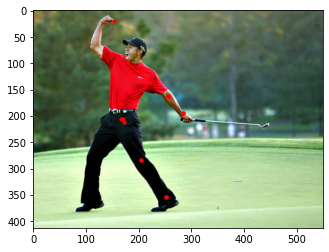

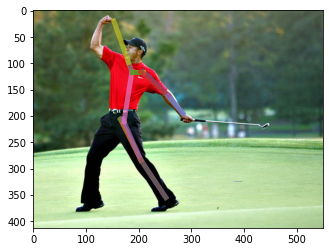

In [29]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# Simplebaseline 모델학습

In [30]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train('baseline' ,epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

#WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models1', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

model = Simplebaseline(IMAGE_SHAPE)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
model.load_weights(best_model_file)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
94781440/94765736 [==============================] - 0s 0us/step
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 11.0837221 epoch total loss 11.0837221
Trained batch 2 batch loss 10.2619896 epoch total loss 10.6728554
Trained batch 3 batch loss 8.03818417 epoch total loss 9.79463196
Trained batch 4 batch loss 6.92673635 epoch total loss 9.0776577
Trained batch 5 batch loss 7.27583361 epoch total loss 8.71729279
Trained batch 6 batch loss 7.65969515 epoch total loss 8.54102612
Trained batch 7 batch loss 7.48616 epoch total loss 8.39033127
Trained batch 8 batch loss 7.26527309 epoch total loss 8.24969864
Trained batch 9 batch loss 6.9141469 epoch total loss 8.10130405
Trained batch 10 batch loss 6.7661252 epoch total loss 7.96778631
Trained batch 11 batch loss 7.16538477 epoch total loss 7.89484072
Trained batch 12 batch

Trained batch 117 batch loss 6.40609074 epoch total loss 6.65879679
Trained batch 118 batch loss 7.08279562 epoch total loss 6.66239
Trained batch 119 batch loss 6.87858534 epoch total loss 6.66420698
Trained batch 120 batch loss 6.670403 epoch total loss 6.66425896
Trained batch 121 batch loss 6.60525274 epoch total loss 6.66377115
Trained batch 122 batch loss 6.77004337 epoch total loss 6.66464186
Trained batch 123 batch loss 6.66653538 epoch total loss 6.66465759
Trained batch 124 batch loss 6.87431479 epoch total loss 6.66634846
Trained batch 125 batch loss 7.02480602 epoch total loss 6.66921568
Trained batch 126 batch loss 6.92912292 epoch total loss 6.67127848
Trained batch 127 batch loss 6.68113613 epoch total loss 6.67135668
Trained batch 128 batch loss 6.58580923 epoch total loss 6.67068815
Trained batch 129 batch loss 6.90104246 epoch total loss 6.67247391
Trained batch 130 batch loss 6.88015413 epoch total loss 6.67407131
Trained batch 131 batch loss 6.44571733 epoch total l

Trained batch 255 batch loss 6.70253563 epoch total loss 6.52437
Trained batch 256 batch loss 6.60681534 epoch total loss 6.52469206
Trained batch 257 batch loss 6.53730822 epoch total loss 6.52474117
Trained batch 258 batch loss 6.4028 epoch total loss 6.52426863
Trained batch 259 batch loss 6.30128336 epoch total loss 6.52340794
Trained batch 260 batch loss 6.22302723 epoch total loss 6.52225256
Trained batch 261 batch loss 6.48902 epoch total loss 6.52212524
Trained batch 262 batch loss 6.44436884 epoch total loss 6.52182817
Trained batch 263 batch loss 5.55496073 epoch total loss 6.51815176
Trained batch 264 batch loss 5.77549601 epoch total loss 6.5153389
Trained batch 265 batch loss 5.95062304 epoch total loss 6.51320791
Trained batch 266 batch loss 6.27185774 epoch total loss 6.51230049
Trained batch 267 batch loss 6.01748133 epoch total loss 6.5104475
Trained batch 268 batch loss 6.80475473 epoch total loss 6.51154566
Trained batch 269 batch loss 6.11484909 epoch total loss 6.5

Trained batch 377 batch loss 6.15356112 epoch total loss 6.49420261
Trained batch 378 batch loss 5.84569597 epoch total loss 6.49248695
Trained batch 379 batch loss 5.74683142 epoch total loss 6.49051952
Trained batch 380 batch loss 6.22907877 epoch total loss 6.48983145
Trained batch 381 batch loss 5.44489431 epoch total loss 6.48708868
Trained batch 382 batch loss 5.52482 epoch total loss 6.48457
Trained batch 383 batch loss 5.28752279 epoch total loss 6.48144484
Trained batch 384 batch loss 5.37592077 epoch total loss 6.47856569
Trained batch 385 batch loss 5.93960285 epoch total loss 6.47716618
Trained batch 386 batch loss 6.32498312 epoch total loss 6.47677183
Trained batch 387 batch loss 6.53242064 epoch total loss 6.47691584
Trained batch 388 batch loss 6.53237915 epoch total loss 6.47705889
Trained batch 389 batch loss 7.07929039 epoch total loss 6.47860718
Trained batch 390 batch loss 6.81141329 epoch total loss 6.47946072
Trained batch 391 batch loss 6.5287571 epoch total los

Trained batch 499 batch loss 5.91659164 epoch total loss 6.46140718
Trained batch 500 batch loss 6.50949955 epoch total loss 6.46150351
Trained batch 501 batch loss 6.75690937 epoch total loss 6.46209288
Trained batch 502 batch loss 6.67477083 epoch total loss 6.46251678
Trained batch 503 batch loss 6.48184633 epoch total loss 6.46255541
Trained batch 504 batch loss 6.5958724 epoch total loss 6.46282
Trained batch 505 batch loss 6.63534546 epoch total loss 6.46316147
Trained batch 506 batch loss 6.68211842 epoch total loss 6.46359396
Trained batch 507 batch loss 6.835989 epoch total loss 6.46432829
Trained batch 508 batch loss 6.70372725 epoch total loss 6.4647994
Trained batch 509 batch loss 6.42549562 epoch total loss 6.46472263
Trained batch 510 batch loss 6.59543371 epoch total loss 6.46497869
Trained batch 511 batch loss 6.56795263 epoch total loss 6.46518
Trained batch 512 batch loss 6.49838 epoch total loss 6.46524477
Trained batch 513 batch loss 6.35088682 epoch total loss 6.46

Trained batch 621 batch loss 6.90483713 epoch total loss 6.4338336
Trained batch 622 batch loss 6.59351873 epoch total loss 6.43409
Trained batch 623 batch loss 6.90047312 epoch total loss 6.43483877
Trained batch 624 batch loss 5.67076206 epoch total loss 6.43361425
Trained batch 625 batch loss 5.6572094 epoch total loss 6.43237209
Trained batch 626 batch loss 6.09421635 epoch total loss 6.43183184
Trained batch 627 batch loss 6.71129 epoch total loss 6.4322772
Trained batch 628 batch loss 6.58253431 epoch total loss 6.43251657
Trained batch 629 batch loss 6.56515312 epoch total loss 6.43272734
Trained batch 630 batch loss 6.21247196 epoch total loss 6.43237782
Trained batch 631 batch loss 6.40013742 epoch total loss 6.43232679
Trained batch 632 batch loss 6.42147493 epoch total loss 6.43230915
Trained batch 633 batch loss 6.50486088 epoch total loss 6.43242407
Trained batch 634 batch loss 6.50152254 epoch total loss 6.43253279
Trained batch 635 batch loss 6.3180337 epoch total loss 6

Trained batch 743 batch loss 6.55607033 epoch total loss 6.42830753
Trained batch 744 batch loss 6.24687529 epoch total loss 6.42806387
Trained batch 745 batch loss 6.1476655 epoch total loss 6.42768717
Trained batch 746 batch loss 6.57391 epoch total loss 6.42788315
Trained batch 747 batch loss 6.42394 epoch total loss 6.42787743
Trained batch 748 batch loss 6.48901272 epoch total loss 6.42795897
Trained batch 749 batch loss 6.67395973 epoch total loss 6.42828703
Trained batch 750 batch loss 6.57624722 epoch total loss 6.42848444
Trained batch 751 batch loss 5.96911907 epoch total loss 6.42787266
Trained batch 752 batch loss 5.88606405 epoch total loss 6.42715263
Trained batch 753 batch loss 6.03440189 epoch total loss 6.4266305
Trained batch 754 batch loss 5.61440659 epoch total loss 6.42555332
Trained batch 755 batch loss 6.08349895 epoch total loss 6.42510033
Trained batch 756 batch loss 6.43004131 epoch total loss 6.425107
Trained batch 757 batch loss 7.01648331 epoch total loss 6

Trained batch 865 batch loss 6.07891846 epoch total loss 6.42720938
Trained batch 866 batch loss 6.31177044 epoch total loss 6.42707634
Trained batch 867 batch loss 6.301229 epoch total loss 6.42693138
Trained batch 868 batch loss 6.08008575 epoch total loss 6.42653179
Trained batch 869 batch loss 6.06871128 epoch total loss 6.42612028
Trained batch 870 batch loss 5.79916573 epoch total loss 6.4254
Trained batch 871 batch loss 6.56176472 epoch total loss 6.42555571
Trained batch 872 batch loss 6.66124821 epoch total loss 6.42582607
Trained batch 873 batch loss 6.80044127 epoch total loss 6.42625523
Trained batch 874 batch loss 6.66584921 epoch total loss 6.42652941
Trained batch 875 batch loss 6.48613834 epoch total loss 6.4265976
Trained batch 876 batch loss 6.46944189 epoch total loss 6.42664623
Trained batch 877 batch loss 6.45465088 epoch total loss 6.42667818
Trained batch 878 batch loss 6.40501928 epoch total loss 6.42665339
Trained batch 879 batch loss 6.15100431 epoch total los

Trained batch 987 batch loss 6.36885643 epoch total loss 6.40978622
Trained batch 988 batch loss 6.6926918 epoch total loss 6.4100728
Trained batch 989 batch loss 6.63844776 epoch total loss 6.41030407
Trained batch 990 batch loss 6.43228436 epoch total loss 6.410326
Trained batch 991 batch loss 6.10484219 epoch total loss 6.41001797
Trained batch 992 batch loss 6.44670391 epoch total loss 6.41005468
Trained batch 993 batch loss 5.99495459 epoch total loss 6.40963697
Trained batch 994 batch loss 6.04779577 epoch total loss 6.40927315
Trained batch 995 batch loss 6.37545204 epoch total loss 6.40923929
Trained batch 996 batch loss 6.00824785 epoch total loss 6.40883636
Trained batch 997 batch loss 6.19061041 epoch total loss 6.4086175
Trained batch 998 batch loss 6.62747288 epoch total loss 6.40883684
Trained batch 999 batch loss 6.11396599 epoch total loss 6.4085412
Trained batch 1000 batch loss 6.25948477 epoch total loss 6.40839195
Trained batch 1001 batch loss 6.3674 epoch total loss

Trained batch 1107 batch loss 6.12224293 epoch total loss 6.41253853
Trained batch 1108 batch loss 6.47908306 epoch total loss 6.41259861
Trained batch 1109 batch loss 6.44612312 epoch total loss 6.41262913
Trained batch 1110 batch loss 6.2793026 epoch total loss 6.41250896
Trained batch 1111 batch loss 6.57862 epoch total loss 6.41265821
Trained batch 1112 batch loss 6.16217422 epoch total loss 6.41243315
Trained batch 1113 batch loss 5.95087 epoch total loss 6.4120183
Trained batch 1114 batch loss 6.09923792 epoch total loss 6.41173744
Trained batch 1115 batch loss 6.16290426 epoch total loss 6.41151428
Trained batch 1116 batch loss 6.01552343 epoch total loss 6.41115952
Trained batch 1117 batch loss 6.23590755 epoch total loss 6.41100264
Trained batch 1118 batch loss 5.80642939 epoch total loss 6.4104619
Trained batch 1119 batch loss 6.00064611 epoch total loss 6.41009569
Trained batch 1120 batch loss 5.97823048 epoch total loss 6.40971
Trained batch 1121 batch loss 5.75806379 epoch

Trained batch 1227 batch loss 6.09329605 epoch total loss 6.41448069
Trained batch 1228 batch loss 6.50848961 epoch total loss 6.41455698
Trained batch 1229 batch loss 6.67279577 epoch total loss 6.41476727
Trained batch 1230 batch loss 6.52101278 epoch total loss 6.41485357
Trained batch 1231 batch loss 6.83257341 epoch total loss 6.41519308
Trained batch 1232 batch loss 6.5999279 epoch total loss 6.41534328
Trained batch 1233 batch loss 6.34718037 epoch total loss 6.41528797
Trained batch 1234 batch loss 6.54766178 epoch total loss 6.41539526
Trained batch 1235 batch loss 6.63719177 epoch total loss 6.41557455
Trained batch 1236 batch loss 6.47251081 epoch total loss 6.4156208
Trained batch 1237 batch loss 5.41455507 epoch total loss 6.41481161
Trained batch 1238 batch loss 5.3177371 epoch total loss 6.41392565
Trained batch 1239 batch loss 5.73080444 epoch total loss 6.41337442
Trained batch 1240 batch loss 5.88575411 epoch total loss 6.41294909
Trained batch 1241 batch loss 6.92928

Trained batch 1347 batch loss 6.41595793 epoch total loss 6.41449738
Trained batch 1348 batch loss 6.47288322 epoch total loss 6.41454077
Trained batch 1349 batch loss 6.40310478 epoch total loss 6.41453218
Trained batch 1350 batch loss 6.6527071 epoch total loss 6.41470861
Trained batch 1351 batch loss 6.7243824 epoch total loss 6.41493797
Trained batch 1352 batch loss 6.10247564 epoch total loss 6.41470671
Trained batch 1353 batch loss 6.35287189 epoch total loss 6.41466093
Trained batch 1354 batch loss 6.10554647 epoch total loss 6.41443253
Trained batch 1355 batch loss 6.20293951 epoch total loss 6.4142766
Trained batch 1356 batch loss 6.37011051 epoch total loss 6.41424417
Trained batch 1357 batch loss 6.59939623 epoch total loss 6.41438055
Trained batch 1358 batch loss 6.54949236 epoch total loss 6.41448
Trained batch 1359 batch loss 6.5549922 epoch total loss 6.41458368
Trained batch 1360 batch loss 6.74324036 epoch total loss 6.41482496
Trained batch 1361 batch loss 7.07693815 

Validated batch 130 batch loss 6.23661566
Validated batch 131 batch loss 6.27454519
Validated batch 132 batch loss 6.23928881
Validated batch 133 batch loss 5.96093369
Validated batch 134 batch loss 5.83229685
Validated batch 135 batch loss 6.35960817
Validated batch 136 batch loss 6.09443569
Validated batch 137 batch loss 6.08004856
Validated batch 138 batch loss 6.35905266
Validated batch 139 batch loss 6.39104366
Validated batch 140 batch loss 6.48023
Validated batch 141 batch loss 6.36020803
Validated batch 142 batch loss 6.42738152
Validated batch 143 batch loss 6.80018902
Validated batch 144 batch loss 6.49669886
Validated batch 145 batch loss 6.5459466
Validated batch 146 batch loss 6.41363811
Validated batch 147 batch loss 6.57814884
Validated batch 148 batch loss 6.43143845
Validated batch 149 batch loss 6.7925725
Validated batch 150 batch loss 6.84182787
Validated batch 151 batch loss 6.01486349
Validated batch 152 batch loss 6.57431602
Validated batch 153 batch loss 6.307334

Trained batch 87 batch loss 6.43734169 epoch total loss 6.37661028
Trained batch 88 batch loss 6.55123186 epoch total loss 6.37859392
Trained batch 89 batch loss 6.6529603 epoch total loss 6.38167667
Trained batch 90 batch loss 6.47863674 epoch total loss 6.38275433
Trained batch 91 batch loss 5.83064365 epoch total loss 6.37668705
Trained batch 92 batch loss 6.40377283 epoch total loss 6.37698078
Trained batch 93 batch loss 6.21642733 epoch total loss 6.37525463
Trained batch 94 batch loss 6.15722656 epoch total loss 6.3729353
Trained batch 95 batch loss 6.31819534 epoch total loss 6.3723588
Trained batch 96 batch loss 6.35328388 epoch total loss 6.37216
Trained batch 97 batch loss 5.96667 epoch total loss 6.36797953
Trained batch 98 batch loss 6.45533657 epoch total loss 6.36887074
Trained batch 99 batch loss 6.5159173 epoch total loss 6.37035656
Trained batch 100 batch loss 6.49771786 epoch total loss 6.37163
Trained batch 101 batch loss 6.28768444 epoch total loss 6.37079906
Traine

Trained batch 209 batch loss 6.6638751 epoch total loss 6.35110378
Trained batch 210 batch loss 6.45479727 epoch total loss 6.35159779
Trained batch 211 batch loss 6.44108915 epoch total loss 6.35202169
Trained batch 212 batch loss 6.45664644 epoch total loss 6.35251522
Trained batch 213 batch loss 6.55824471 epoch total loss 6.35348129
Trained batch 214 batch loss 6.12294579 epoch total loss 6.35240364
Trained batch 215 batch loss 5.65803242 epoch total loss 6.3491745
Trained batch 216 batch loss 5.95537853 epoch total loss 6.34735107
Trained batch 217 batch loss 6.190166 epoch total loss 6.34662676
Trained batch 218 batch loss 6.02246618 epoch total loss 6.34514
Trained batch 219 batch loss 6.33958054 epoch total loss 6.34511471
Trained batch 220 batch loss 6.2996254 epoch total loss 6.34490824
Trained batch 221 batch loss 6.44148254 epoch total loss 6.34534502
Trained batch 222 batch loss 6.84693384 epoch total loss 6.34760475
Trained batch 223 batch loss 6.49621964 epoch total loss

Trained batch 331 batch loss 6.24434805 epoch total loss 6.38380527
Trained batch 332 batch loss 6.38947582 epoch total loss 6.38382196
Trained batch 333 batch loss 6.49008846 epoch total loss 6.38414097
Trained batch 334 batch loss 6.25213814 epoch total loss 6.38374615
Trained batch 335 batch loss 6.60407066 epoch total loss 6.38440323
Trained batch 336 batch loss 6.32439804 epoch total loss 6.38422489
Trained batch 337 batch loss 6.18168068 epoch total loss 6.38362408
Trained batch 338 batch loss 6.34744692 epoch total loss 6.38351679
Trained batch 339 batch loss 6.69544125 epoch total loss 6.38443708
Trained batch 340 batch loss 6.52696133 epoch total loss 6.38485622
Trained batch 341 batch loss 6.72113705 epoch total loss 6.38584232
Trained batch 342 batch loss 6.73421574 epoch total loss 6.38686085
Trained batch 343 batch loss 6.51571274 epoch total loss 6.38723612
Trained batch 344 batch loss 6.30685425 epoch total loss 6.38700247
Trained batch 345 batch loss 6.68841553 epoch to

Trained batch 453 batch loss 6.34038687 epoch total loss 6.36919594
Trained batch 454 batch loss 6.49412346 epoch total loss 6.36947155
Trained batch 455 batch loss 6.23081541 epoch total loss 6.36916637
Trained batch 456 batch loss 6.30011034 epoch total loss 6.36901474
Trained batch 457 batch loss 6.23221064 epoch total loss 6.36871529
Trained batch 458 batch loss 6.32775116 epoch total loss 6.36862564
Trained batch 459 batch loss 5.86468077 epoch total loss 6.36752796
Trained batch 460 batch loss 6.39562559 epoch total loss 6.36758852
Trained batch 461 batch loss 6.61131048 epoch total loss 6.36811733
Trained batch 462 batch loss 6.73028374 epoch total loss 6.36890125
Trained batch 463 batch loss 6.24871778 epoch total loss 6.36864185
Trained batch 464 batch loss 6.21841097 epoch total loss 6.36831808
Trained batch 465 batch loss 6.23967028 epoch total loss 6.36804152
Trained batch 466 batch loss 6.26266718 epoch total loss 6.36781549
Trained batch 467 batch loss 6.38030243 epoch to

Trained batch 575 batch loss 6.6378274 epoch total loss 6.35706043
Trained batch 576 batch loss 6.27337122 epoch total loss 6.35691547
Trained batch 577 batch loss 6.38832283 epoch total loss 6.35697
Trained batch 578 batch loss 6.61024714 epoch total loss 6.35740852
Trained batch 579 batch loss 6.83164 epoch total loss 6.35822725
Trained batch 580 batch loss 7.03192759 epoch total loss 6.35938883
Trained batch 581 batch loss 7.38183 epoch total loss 6.36114883
Trained batch 582 batch loss 7.34052229 epoch total loss 6.36283159
Trained batch 583 batch loss 7.06942415 epoch total loss 6.36404324
Trained batch 584 batch loss 7.40485048 epoch total loss 6.36582565
Trained batch 585 batch loss 6.35026455 epoch total loss 6.36579895
Trained batch 586 batch loss 6.38146734 epoch total loss 6.36582565
Trained batch 587 batch loss 6.50080061 epoch total loss 6.36605549
Trained batch 588 batch loss 6.00467682 epoch total loss 6.36544085
Trained batch 589 batch loss 6.34784889 epoch total loss 6

Trained batch 697 batch loss 5.89169693 epoch total loss 6.36332417
Trained batch 698 batch loss 6.20973778 epoch total loss 6.36310434
Trained batch 699 batch loss 6.7755394 epoch total loss 6.36369419
Trained batch 700 batch loss 6.71196556 epoch total loss 6.36419153
Trained batch 701 batch loss 6.30276728 epoch total loss 6.36410379
Trained batch 702 batch loss 6.18526745 epoch total loss 6.36384869
Trained batch 703 batch loss 6.35607624 epoch total loss 6.36383772
Trained batch 704 batch loss 6.67710876 epoch total loss 6.36428261
Trained batch 705 batch loss 6.49746084 epoch total loss 6.36447191
Trained batch 706 batch loss 6.48089 epoch total loss 6.3646369
Trained batch 707 batch loss 6.60348272 epoch total loss 6.3649745
Trained batch 708 batch loss 6.71367 epoch total loss 6.36546755
Trained batch 709 batch loss 6.57326031 epoch total loss 6.36576033
Trained batch 710 batch loss 6.54192924 epoch total loss 6.36600876
Trained batch 711 batch loss 6.446805 epoch total loss 6.

Trained batch 819 batch loss 6.58750582 epoch total loss 6.37473249
Trained batch 820 batch loss 6.34544563 epoch total loss 6.37469625
Trained batch 821 batch loss 6.17070103 epoch total loss 6.3744483
Trained batch 822 batch loss 6.18999624 epoch total loss 6.37422371
Trained batch 823 batch loss 6.0236578 epoch total loss 6.37379742
Trained batch 824 batch loss 5.83342695 epoch total loss 6.37314177
Trained batch 825 batch loss 6.2994175 epoch total loss 6.37305212
Trained batch 826 batch loss 6.66834831 epoch total loss 6.37340975
Trained batch 827 batch loss 6.51510906 epoch total loss 6.37358141
Trained batch 828 batch loss 6.57255888 epoch total loss 6.37382174
Trained batch 829 batch loss 6.55147171 epoch total loss 6.37403584
Trained batch 830 batch loss 6.5787816 epoch total loss 6.37428236
Trained batch 831 batch loss 6.50887632 epoch total loss 6.37444401
Trained batch 832 batch loss 6.70808363 epoch total loss 6.37484503
Trained batch 833 batch loss 6.504498 epoch total lo

Trained batch 941 batch loss 5.9621954 epoch total loss 6.37045193
Trained batch 942 batch loss 6.37734 epoch total loss 6.37045908
Trained batch 943 batch loss 6.45415735 epoch total loss 6.37054777
Trained batch 944 batch loss 6.47793913 epoch total loss 6.37066174
Trained batch 945 batch loss 6.50773668 epoch total loss 6.37080717
Trained batch 946 batch loss 5.88881397 epoch total loss 6.37029743
Trained batch 947 batch loss 6.27901 epoch total loss 6.37020063
Trained batch 948 batch loss 6.23263264 epoch total loss 6.3700552
Trained batch 949 batch loss 6.52718973 epoch total loss 6.37022114
Trained batch 950 batch loss 6.16898727 epoch total loss 6.37000942
Trained batch 951 batch loss 6.08706045 epoch total loss 6.3697114
Trained batch 952 batch loss 6.26576233 epoch total loss 6.3696022
Trained batch 953 batch loss 6.22932243 epoch total loss 6.36945534
Trained batch 954 batch loss 6.12103605 epoch total loss 6.36919498
Trained batch 955 batch loss 6.11427975 epoch total loss 6

Trained batch 1062 batch loss 5.95894718 epoch total loss 6.36734819
Trained batch 1063 batch loss 6.16589928 epoch total loss 6.36715841
Trained batch 1064 batch loss 6.22402763 epoch total loss 6.36702394
Trained batch 1065 batch loss 5.99748516 epoch total loss 6.36667728
Trained batch 1066 batch loss 5.62560368 epoch total loss 6.36598206
Trained batch 1067 batch loss 5.62909412 epoch total loss 6.36529112
Trained batch 1068 batch loss 6.05150223 epoch total loss 6.36499691
Trained batch 1069 batch loss 6.0924716 epoch total loss 6.3647418
Trained batch 1070 batch loss 6.08956718 epoch total loss 6.36448479
Trained batch 1071 batch loss 6.27039385 epoch total loss 6.36439705
Trained batch 1072 batch loss 6.18539095 epoch total loss 6.36423
Trained batch 1073 batch loss 6.30529594 epoch total loss 6.36417484
Trained batch 1074 batch loss 6.48987103 epoch total loss 6.36429214
Trained batch 1075 batch loss 6.51890945 epoch total loss 6.36443567
Trained batch 1076 batch loss 6.5622243

Trained batch 1182 batch loss 6.02274179 epoch total loss 6.35774946
Trained batch 1183 batch loss 6.48206186 epoch total loss 6.35785437
Trained batch 1184 batch loss 6.27432 epoch total loss 6.35778379
Trained batch 1185 batch loss 6.18273163 epoch total loss 6.35763597
Trained batch 1186 batch loss 6.06667614 epoch total loss 6.35739088
Trained batch 1187 batch loss 5.82988834 epoch total loss 6.35694695
Trained batch 1188 batch loss 6.04558659 epoch total loss 6.35668468
Trained batch 1189 batch loss 6.32961464 epoch total loss 6.3566618
Trained batch 1190 batch loss 5.88690948 epoch total loss 6.35626698
Trained batch 1191 batch loss 6.30702639 epoch total loss 6.35622549
Trained batch 1192 batch loss 6.46514416 epoch total loss 6.35631704
Trained batch 1193 batch loss 6.69701099 epoch total loss 6.35660267
Trained batch 1194 batch loss 6.39658689 epoch total loss 6.35663605
Trained batch 1195 batch loss 6.22088718 epoch total loss 6.35652208
Trained batch 1196 batch loss 6.144325

Trained batch 1302 batch loss 6.08343124 epoch total loss 6.3575139
Trained batch 1303 batch loss 6.46508694 epoch total loss 6.3575964
Trained batch 1304 batch loss 7.17326355 epoch total loss 6.35822153
Trained batch 1305 batch loss 6.78867722 epoch total loss 6.35855198
Trained batch 1306 batch loss 6.7627039 epoch total loss 6.35886145
Trained batch 1307 batch loss 7.09555721 epoch total loss 6.35942507
Trained batch 1308 batch loss 7.18472719 epoch total loss 6.36005592
Trained batch 1309 batch loss 6.61266613 epoch total loss 6.36024857
Trained batch 1310 batch loss 6.35684586 epoch total loss 6.3602457
Trained batch 1311 batch loss 6.52574587 epoch total loss 6.36037159
Trained batch 1312 batch loss 6.35828495 epoch total loss 6.36037
Trained batch 1313 batch loss 6.18590879 epoch total loss 6.36023712
Trained batch 1314 batch loss 6.72887611 epoch total loss 6.3605175
Trained batch 1315 batch loss 6.41345692 epoch total loss 6.36055708
Trained batch 1316 batch loss 6.03413 epoc

Validated batch 56 batch loss 6.41238594
Validated batch 57 batch loss 6.14021349
Validated batch 58 batch loss 6.36065626
Validated batch 59 batch loss 6.23265934
Validated batch 60 batch loss 6.6309
Validated batch 61 batch loss 6.53148842
Validated batch 62 batch loss 6.20735931
Validated batch 63 batch loss 6.55812454
Validated batch 64 batch loss 5.87709236
Validated batch 65 batch loss 6.38402414
Validated batch 66 batch loss 6.47940826
Validated batch 67 batch loss 6.38378811
Validated batch 68 batch loss 6.54768038
Validated batch 69 batch loss 6.11439323
Validated batch 70 batch loss 6.41780329
Validated batch 71 batch loss 6.33652735
Validated batch 72 batch loss 6.09566927
Validated batch 73 batch loss 6.10981607
Validated batch 74 batch loss 6.42119837
Validated batch 75 batch loss 6.33942652
Validated batch 76 batch loss 6.40200281
Validated batch 77 batch loss 6.30758
Validated batch 78 batch loss 6.17045975
Validated batch 79 batch loss 6.62944555
Validated batch 80 batc

Trained batch 41 batch loss 6.33462715 epoch total loss 6.42077637
Trained batch 42 batch loss 6.12265444 epoch total loss 6.41367817
Trained batch 43 batch loss 6.41456032 epoch total loss 6.4136982
Trained batch 44 batch loss 6.05480909 epoch total loss 6.4055419
Trained batch 45 batch loss 6.22106028 epoch total loss 6.40144253
Trained batch 46 batch loss 6.35100174 epoch total loss 6.40034628
Trained batch 47 batch loss 6.49002171 epoch total loss 6.4022541
Trained batch 48 batch loss 6.80720091 epoch total loss 6.41069031
Trained batch 49 batch loss 6.09181595 epoch total loss 6.40418291
Trained batch 50 batch loss 6.50567 epoch total loss 6.40621281
Trained batch 51 batch loss 6.3859849 epoch total loss 6.40581608
Trained batch 52 batch loss 6.62956238 epoch total loss 6.41011858
Trained batch 53 batch loss 6.45811462 epoch total loss 6.41102457
Trained batch 54 batch loss 6.32409668 epoch total loss 6.40941477
Trained batch 55 batch loss 6.47515869 epoch total loss 6.41061
Train

Trained batch 164 batch loss 6.44992733 epoch total loss 6.3458662
Trained batch 165 batch loss 6.33705044 epoch total loss 6.3458128
Trained batch 166 batch loss 6.78733826 epoch total loss 6.3484726
Trained batch 167 batch loss 5.0629797 epoch total loss 6.34077501
Trained batch 168 batch loss 4.98234749 epoch total loss 6.33268881
Trained batch 169 batch loss 5.17221165 epoch total loss 6.32582235
Trained batch 170 batch loss 6.94324303 epoch total loss 6.32945395
Trained batch 171 batch loss 6.95704174 epoch total loss 6.33312416
Trained batch 172 batch loss 7.15868378 epoch total loss 6.337924
Trained batch 173 batch loss 6.81958818 epoch total loss 6.34070826
Trained batch 174 batch loss 6.64794254 epoch total loss 6.34247398
Trained batch 175 batch loss 6.15654898 epoch total loss 6.34141111
Trained batch 176 batch loss 6.27589512 epoch total loss 6.3410387
Trained batch 177 batch loss 6.10979462 epoch total loss 6.33973217
Trained batch 178 batch loss 6.34232092 epoch total los

Trained batch 286 batch loss 5.87850523 epoch total loss 6.34546328
Trained batch 287 batch loss 6.19230938 epoch total loss 6.34492922
Trained batch 288 batch loss 6.20525265 epoch total loss 6.34444427
Trained batch 289 batch loss 6.37874413 epoch total loss 6.34456301
Trained batch 290 batch loss 6.41198254 epoch total loss 6.3447957
Trained batch 291 batch loss 6.27920437 epoch total loss 6.34457
Trained batch 292 batch loss 5.32955837 epoch total loss 6.34109402
Trained batch 293 batch loss 5.53309774 epoch total loss 6.33833647
Trained batch 294 batch loss 5.6629734 epoch total loss 6.33603907
Trained batch 295 batch loss 6.12938118 epoch total loss 6.33533859
Trained batch 296 batch loss 5.99258518 epoch total loss 6.33418083
Trained batch 297 batch loss 6.48888063 epoch total loss 6.33470154
Trained batch 298 batch loss 6.07848215 epoch total loss 6.3338418
Trained batch 299 batch loss 6.19601107 epoch total loss 6.33338118
Trained batch 300 batch loss 6.1182642 epoch total los

Trained batch 408 batch loss 6.48945618 epoch total loss 6.34941435
Trained batch 409 batch loss 6.43682528 epoch total loss 6.34962797
Trained batch 410 batch loss 6.50322342 epoch total loss 6.35000229
Trained batch 411 batch loss 6.44283152 epoch total loss 6.35022831
Trained batch 412 batch loss 6.32592678 epoch total loss 6.35016918
Trained batch 413 batch loss 6.12995148 epoch total loss 6.34963608
Trained batch 414 batch loss 6.36129761 epoch total loss 6.34966421
Trained batch 415 batch loss 6.48728466 epoch total loss 6.34999609
Trained batch 416 batch loss 6.40959787 epoch total loss 6.35013914
Trained batch 417 batch loss 6.54946709 epoch total loss 6.35061741
Trained batch 418 batch loss 6.36857367 epoch total loss 6.3506608
Trained batch 419 batch loss 6.36162853 epoch total loss 6.35068655
Trained batch 420 batch loss 6.38950157 epoch total loss 6.35077906
Trained batch 421 batch loss 6.38469887 epoch total loss 6.35085964
Trained batch 422 batch loss 6.52207756 epoch tot

Trained batch 530 batch loss 6.23705292 epoch total loss 6.36813259
Trained batch 531 batch loss 6.36810732 epoch total loss 6.36813259
Trained batch 532 batch loss 6.40621519 epoch total loss 6.36820459
Trained batch 533 batch loss 6.11008072 epoch total loss 6.36772
Trained batch 534 batch loss 5.84471941 epoch total loss 6.3667407
Trained batch 535 batch loss 6.00219584 epoch total loss 6.3660593
Trained batch 536 batch loss 6.4215765 epoch total loss 6.36616325
Trained batch 537 batch loss 6.48575258 epoch total loss 6.36638594
Trained batch 538 batch loss 6.55818653 epoch total loss 6.36674213
Trained batch 539 batch loss 6.59652042 epoch total loss 6.36716843
Trained batch 540 batch loss 6.51737213 epoch total loss 6.36744642
Trained batch 541 batch loss 6.18940163 epoch total loss 6.3671174
Trained batch 542 batch loss 5.77373409 epoch total loss 6.36602259
Trained batch 543 batch loss 5.85737 epoch total loss 6.36508608
Trained batch 544 batch loss 6.38367653 epoch total loss 6

Trained batch 652 batch loss 6.49274111 epoch total loss 6.37984371
Trained batch 653 batch loss 6.68481064 epoch total loss 6.38031054
Trained batch 654 batch loss 6.60924339 epoch total loss 6.38066101
Trained batch 655 batch loss 6.83192 epoch total loss 6.38135
Trained batch 656 batch loss 6.94814825 epoch total loss 6.38221407
Trained batch 657 batch loss 6.50551605 epoch total loss 6.38240147
Trained batch 658 batch loss 6.06197834 epoch total loss 6.38191462
Trained batch 659 batch loss 6.09449577 epoch total loss 6.38147879
Trained batch 660 batch loss 5.87749863 epoch total loss 6.38071489
Trained batch 661 batch loss 5.4989543 epoch total loss 6.37938118
Trained batch 662 batch loss 6.25842381 epoch total loss 6.37919855
Trained batch 663 batch loss 5.62972689 epoch total loss 6.37806797
Trained batch 664 batch loss 5.18286371 epoch total loss 6.37626839
Trained batch 665 batch loss 4.96287489 epoch total loss 6.37414312
Trained batch 666 batch loss 5.37170887 epoch total los

Trained batch 774 batch loss 6.44209766 epoch total loss 6.36267328
Trained batch 775 batch loss 6.52686644 epoch total loss 6.362885
Trained batch 776 batch loss 6.21857166 epoch total loss 6.36269903
Trained batch 777 batch loss 6.16845322 epoch total loss 6.36244917
Trained batch 778 batch loss 6.35087872 epoch total loss 6.36243439
Trained batch 779 batch loss 6.24665356 epoch total loss 6.36228609
Trained batch 780 batch loss 6.19367504 epoch total loss 6.36207
Trained batch 781 batch loss 6.23690128 epoch total loss 6.36190939
Trained batch 782 batch loss 6.04956198 epoch total loss 6.36151028
Trained batch 783 batch loss 6.32012367 epoch total loss 6.36145782
Trained batch 784 batch loss 6.27259159 epoch total loss 6.36134434
Trained batch 785 batch loss 6.08165503 epoch total loss 6.36098766
Trained batch 786 batch loss 6.53064919 epoch total loss 6.36120367
Trained batch 787 batch loss 6.51316309 epoch total loss 6.36139679
Trained batch 788 batch loss 6.49260378 epoch total l

Trained batch 896 batch loss 5.8756814 epoch total loss 6.36046362
Trained batch 897 batch loss 6.92153549 epoch total loss 6.36108923
Trained batch 898 batch loss 6.71290541 epoch total loss 6.36148071
Trained batch 899 batch loss 6.65967083 epoch total loss 6.36181259
Trained batch 900 batch loss 6.74945211 epoch total loss 6.36224318
Trained batch 901 batch loss 7.03053951 epoch total loss 6.36298513
Trained batch 902 batch loss 6.78728485 epoch total loss 6.36345577
Trained batch 903 batch loss 6.75314283 epoch total loss 6.36388683
Trained batch 904 batch loss 6.60298538 epoch total loss 6.36415148
Trained batch 905 batch loss 6.55728245 epoch total loss 6.36436462
Trained batch 906 batch loss 6.9091754 epoch total loss 6.36496592
Trained batch 907 batch loss 6.29488087 epoch total loss 6.36488867
Trained batch 908 batch loss 6.58046103 epoch total loss 6.36512613
Trained batch 909 batch loss 6.13169 epoch total loss 6.36486959
Trained batch 910 batch loss 5.76832914 epoch total l

Trained batch 1018 batch loss 5.86020184 epoch total loss 6.3563242
Trained batch 1019 batch loss 6.76075172 epoch total loss 6.35672092
Trained batch 1020 batch loss 7.15314865 epoch total loss 6.35750198
Trained batch 1021 batch loss 6.62587833 epoch total loss 6.35776472
Trained batch 1022 batch loss 6.54637289 epoch total loss 6.35794926
Trained batch 1023 batch loss 6.43329048 epoch total loss 6.35802269
Trained batch 1024 batch loss 6.78188896 epoch total loss 6.35843658
Trained batch 1025 batch loss 6.42559767 epoch total loss 6.35850239
Trained batch 1026 batch loss 6.37497044 epoch total loss 6.3585186
Trained batch 1027 batch loss 6.52224 epoch total loss 6.35867786
Trained batch 1028 batch loss 6.32024288 epoch total loss 6.35864067
Trained batch 1029 batch loss 6.24555874 epoch total loss 6.358531
Trained batch 1030 batch loss 6.55001831 epoch total loss 6.35871649
Trained batch 1031 batch loss 6.76742125 epoch total loss 6.35911322
Trained batch 1032 batch loss 6.53654289 

Trained batch 1138 batch loss 6.61734629 epoch total loss 6.36420059
Trained batch 1139 batch loss 6.79821825 epoch total loss 6.36458206
Trained batch 1140 batch loss 6.77009249 epoch total loss 6.36493778
Trained batch 1141 batch loss 6.74266577 epoch total loss 6.36526871
Trained batch 1142 batch loss 6.7488637 epoch total loss 6.36560488
Trained batch 1143 batch loss 6.82748222 epoch total loss 6.36600876
Trained batch 1144 batch loss 6.63613844 epoch total loss 6.36624527
Trained batch 1145 batch loss 6.81835222 epoch total loss 6.36664
Trained batch 1146 batch loss 6.68083 epoch total loss 6.3669138
Trained batch 1147 batch loss 6.4344883 epoch total loss 6.36697292
Trained batch 1148 batch loss 6.66006041 epoch total loss 6.36722851
Trained batch 1149 batch loss 6.27497 epoch total loss 6.36714792
Trained batch 1150 batch loss 6.57745934 epoch total loss 6.36733103
Trained batch 1151 batch loss 6.67293596 epoch total loss 6.36759663
Trained batch 1152 batch loss 7.02215242 epoch

Trained batch 1258 batch loss 5.40391541 epoch total loss 6.36581373
Trained batch 1259 batch loss 6.16778517 epoch total loss 6.36565685
Trained batch 1260 batch loss 6.92941523 epoch total loss 6.36610413
Trained batch 1261 batch loss 7.05436373 epoch total loss 6.36664963
Trained batch 1262 batch loss 6.68316126 epoch total loss 6.36690044
Trained batch 1263 batch loss 7.07969713 epoch total loss 6.36746454
Trained batch 1264 batch loss 7.18950891 epoch total loss 6.36811495
Trained batch 1265 batch loss 6.66306496 epoch total loss 6.36834812
Trained batch 1266 batch loss 5.99865532 epoch total loss 6.3680563
Trained batch 1267 batch loss 6.46412659 epoch total loss 6.36813211
Trained batch 1268 batch loss 6.67002583 epoch total loss 6.36837
Trained batch 1269 batch loss 6.22226238 epoch total loss 6.36825466
Trained batch 1270 batch loss 6.41209173 epoch total loss 6.36828947
Trained batch 1271 batch loss 6.3838377 epoch total loss 6.36830139
Trained batch 1272 batch loss 6.6608376

Trained batch 1378 batch loss 6.01743269 epoch total loss 6.36163
Trained batch 1379 batch loss 5.81680393 epoch total loss 6.36123466
Trained batch 1380 batch loss 5.67014837 epoch total loss 6.36073351
Trained batch 1381 batch loss 6.2247076 epoch total loss 6.36063528
Trained batch 1382 batch loss 6.19143963 epoch total loss 6.36051273
Trained batch 1383 batch loss 6.04084921 epoch total loss 6.36028147
Trained batch 1384 batch loss 6.5112772 epoch total loss 6.36039114
Trained batch 1385 batch loss 6.4096 epoch total loss 6.36042643
Trained batch 1386 batch loss 6.52097893 epoch total loss 6.36054182
Trained batch 1387 batch loss 6.44103622 epoch total loss 6.3606
Trained batch 1388 batch loss 6.37864351 epoch total loss 6.36061335
Epoch 3 train loss 6.3606133460998535
Validated batch 1 batch loss 6.29231405
Validated batch 2 batch loss 6.27238512
Validated batch 3 batch loss 6.12236
Validated batch 4 batch loss 6.98933125
Validated batch 5 batch loss 6.48834658
Validated batch 6 b

Validated batch 182 batch loss 6.26313162
Validated batch 183 batch loss 5.78801489
Validated batch 184 batch loss 6.48726702
Validated batch 185 batch loss 3.26292753
Epoch 3 val loss 6.3064494132995605
Model /aiffel/aiffel/mpii/models1/simple_baseline-epoch-3-loss-6.3064.h5 saved.
Start epoch 4 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 6.74899578 epoch total loss 6.74899578
Trained batch 2 batch loss 6.7241 epoch total loss 6.73654795
Trained batch 3 batch loss 6.69171143 epoch total loss 6.72160196
Trained batch 4 batch loss 6.61567307 epoch total loss 6.69512
Trained batch 5 batch loss 6.39317703 epoch total loss 6.63473129
Trained batch 6 batch loss 6.26396036 epoch total loss 6.57293653
Trained batch 7 batch loss 6.58757496 epoch total loss 6.57502747
Trained batch 8 batch loss 6.75148439 epoch total loss 6.59708452
Trained batch 9 batch loss 6.85656118 epoch total loss 6.62591505
Trained batch 10 batch loss 6.94004965 epoch total loss 6.

Trained batch 119 batch loss 6.41483784 epoch total loss 6.39128733
Trained batch 120 batch loss 6.40213203 epoch total loss 6.39137793
Trained batch 121 batch loss 6.20550489 epoch total loss 6.38984156
Trained batch 122 batch loss 6.42172384 epoch total loss 6.39010334
Trained batch 123 batch loss 6.57260847 epoch total loss 6.39158726
Trained batch 124 batch loss 6.36622047 epoch total loss 6.39138269
Trained batch 125 batch loss 6.3706708 epoch total loss 6.39121675
Trained batch 126 batch loss 6.74796391 epoch total loss 6.39404821
Trained batch 127 batch loss 6.5856 epoch total loss 6.39555645
Trained batch 128 batch loss 6.57813 epoch total loss 6.39698267
Trained batch 129 batch loss 6.43671799 epoch total loss 6.39729071
Trained batch 130 batch loss 6.24374294 epoch total loss 6.3961091
Trained batch 131 batch loss 5.95826149 epoch total loss 6.39276695
Trained batch 132 batch loss 5.93505239 epoch total loss 6.38929939
Trained batch 133 batch loss 6.56842136 epoch total loss 

Trained batch 241 batch loss 7.09369373 epoch total loss 6.37737846
Trained batch 242 batch loss 6.87775755 epoch total loss 6.37944651
Trained batch 243 batch loss 6.83274 epoch total loss 6.38131189
Trained batch 244 batch loss 6.81889629 epoch total loss 6.38310528
Trained batch 245 batch loss 7.01968956 epoch total loss 6.38570309
Trained batch 246 batch loss 6.74087238 epoch total loss 6.38714695
Trained batch 247 batch loss 5.95592785 epoch total loss 6.38540125
Trained batch 248 batch loss 6.7729311 epoch total loss 6.38696384
Trained batch 249 batch loss 6.52695322 epoch total loss 6.38752604
Trained batch 250 batch loss 6.11735249 epoch total loss 6.38644552
Trained batch 251 batch loss 6.53470182 epoch total loss 6.38703585
Trained batch 252 batch loss 6.3962965 epoch total loss 6.38707256
Trained batch 253 batch loss 6.27219915 epoch total loss 6.38661861
Trained batch 254 batch loss 6.30357313 epoch total loss 6.3862915
Trained batch 255 batch loss 6.35794973 epoch total lo

Trained batch 363 batch loss 6.6754179 epoch total loss 6.3775444
Trained batch 364 batch loss 7.02531481 epoch total loss 6.37932396
Trained batch 365 batch loss 7.32735109 epoch total loss 6.38192177
Trained batch 366 batch loss 6.79350615 epoch total loss 6.38304615
Trained batch 367 batch loss 6.51444578 epoch total loss 6.38340378
Trained batch 368 batch loss 6.46658611 epoch total loss 6.38363
Trained batch 369 batch loss 6.32845306 epoch total loss 6.38348
Trained batch 370 batch loss 6.50921535 epoch total loss 6.38382
Trained batch 371 batch loss 5.94915485 epoch total loss 6.38264847
Trained batch 372 batch loss 5.72029114 epoch total loss 6.38086796
Trained batch 373 batch loss 5.88765 epoch total loss 6.37954569
Trained batch 374 batch loss 5.79383135 epoch total loss 6.37797976
Trained batch 375 batch loss 7.39122391 epoch total loss 6.38068151
Trained batch 376 batch loss 6.96843433 epoch total loss 6.38224506
Trained batch 377 batch loss 6.75775909 epoch total loss 6.383

Trained batch 485 batch loss 6.72170353 epoch total loss 6.37262154
Trained batch 486 batch loss 7.01573944 epoch total loss 6.37394476
Trained batch 487 batch loss 6.81027031 epoch total loss 6.37484074
Trained batch 488 batch loss 6.80332756 epoch total loss 6.37571859
Trained batch 489 batch loss 6.76742506 epoch total loss 6.3765192
Trained batch 490 batch loss 6.83762264 epoch total loss 6.37746048
Trained batch 491 batch loss 6.62750912 epoch total loss 6.37796926
Trained batch 492 batch loss 6.49835491 epoch total loss 6.37821388
Trained batch 493 batch loss 6.72193766 epoch total loss 6.37891102
Trained batch 494 batch loss 6.78991604 epoch total loss 6.3797431
Trained batch 495 batch loss 6.51551056 epoch total loss 6.38001728
Trained batch 496 batch loss 6.58137608 epoch total loss 6.38042307
Trained batch 497 batch loss 6.05919504 epoch total loss 6.37977648
Trained batch 498 batch loss 5.73973799 epoch total loss 6.3784914
Trained batch 499 batch loss 5.92673826 epoch total

Trained batch 607 batch loss 6.41044664 epoch total loss 6.35347939
Trained batch 608 batch loss 6.74018097 epoch total loss 6.35411549
Trained batch 609 batch loss 6.94051075 epoch total loss 6.35507822
Trained batch 610 batch loss 6.72337866 epoch total loss 6.3556819
Trained batch 611 batch loss 6.20698833 epoch total loss 6.35543871
Trained batch 612 batch loss 6.45574284 epoch total loss 6.35560274
Trained batch 613 batch loss 6.18555403 epoch total loss 6.35532522
Trained batch 614 batch loss 6.53185129 epoch total loss 6.35561275
Trained batch 615 batch loss 6.69521809 epoch total loss 6.35616493
Trained batch 616 batch loss 6.28105879 epoch total loss 6.35604286
Trained batch 617 batch loss 6.63208675 epoch total loss 6.35649061
Trained batch 618 batch loss 6.06555176 epoch total loss 6.3560195
Trained batch 619 batch loss 6.38403511 epoch total loss 6.3560648
Trained batch 620 batch loss 6.53430462 epoch total loss 6.35635233
Trained batch 621 batch loss 6.6814909 epoch total 

Trained batch 729 batch loss 5.69018126 epoch total loss 6.34546137
Trained batch 730 batch loss 6.40927267 epoch total loss 6.34554863
Trained batch 731 batch loss 6.23992062 epoch total loss 6.34540367
Trained batch 732 batch loss 6.38967419 epoch total loss 6.34546423
Trained batch 733 batch loss 6.38377237 epoch total loss 6.34551668
Trained batch 734 batch loss 6.57469702 epoch total loss 6.34582901
Trained batch 735 batch loss 6.57351828 epoch total loss 6.34613895
Trained batch 736 batch loss 6.7484 epoch total loss 6.34668589
Trained batch 737 batch loss 6.61115 epoch total loss 6.34704494
Trained batch 738 batch loss 6.38644218 epoch total loss 6.34709787
Trained batch 739 batch loss 6.26843309 epoch total loss 6.34699154
Trained batch 740 batch loss 5.83318377 epoch total loss 6.34629679
Trained batch 741 batch loss 5.52121925 epoch total loss 6.34518337
Trained batch 742 batch loss 6.06329966 epoch total loss 6.34480333
Trained batch 743 batch loss 5.89017582 epoch total los

Trained batch 851 batch loss 6.43233919 epoch total loss 6.3504262
Trained batch 852 batch loss 6.27397346 epoch total loss 6.35033655
Trained batch 853 batch loss 6.56667328 epoch total loss 6.35059071
Trained batch 854 batch loss 6.16058826 epoch total loss 6.35036802
Trained batch 855 batch loss 6.45476103 epoch total loss 6.35049
Trained batch 856 batch loss 6.50097084 epoch total loss 6.35066557
Trained batch 857 batch loss 6.15435314 epoch total loss 6.35043669
Trained batch 858 batch loss 6.2088 epoch total loss 6.3502717
Trained batch 859 batch loss 6.17220402 epoch total loss 6.35006475
Trained batch 860 batch loss 6.11671066 epoch total loss 6.34979343
Trained batch 861 batch loss 6.33578634 epoch total loss 6.34977722
Trained batch 862 batch loss 6.37615967 epoch total loss 6.34980774
Trained batch 863 batch loss 6.50432253 epoch total loss 6.34998655
Trained batch 864 batch loss 6.36915493 epoch total loss 6.35000896
Trained batch 865 batch loss 6.29089165 epoch total loss 

Trained batch 973 batch loss 5.99030638 epoch total loss 6.3506074
Trained batch 974 batch loss 6.58187771 epoch total loss 6.35084534
Trained batch 975 batch loss 6.51541662 epoch total loss 6.35101414
Trained batch 976 batch loss 6.43849277 epoch total loss 6.35110378
Trained batch 977 batch loss 6.23258066 epoch total loss 6.35098219
Trained batch 978 batch loss 6.26639938 epoch total loss 6.35089588
Trained batch 979 batch loss 6.41934681 epoch total loss 6.35096598
Trained batch 980 batch loss 6.35173368 epoch total loss 6.35096645
Trained batch 981 batch loss 6.52868366 epoch total loss 6.35114765
Trained batch 982 batch loss 6.44816875 epoch total loss 6.35124683
Trained batch 983 batch loss 6.33958435 epoch total loss 6.35123444
Trained batch 984 batch loss 5.9845643 epoch total loss 6.35086203
Trained batch 985 batch loss 6.00963783 epoch total loss 6.35051537
Trained batch 986 batch loss 6.38787317 epoch total loss 6.35055304
Trained batch 987 batch loss 6.57311726 epoch tota

Trained batch 1093 batch loss 6.49704313 epoch total loss 6.34635973
Trained batch 1094 batch loss 6.36316538 epoch total loss 6.34637547
Trained batch 1095 batch loss 6.68535185 epoch total loss 6.34668493
Trained batch 1096 batch loss 6.52765465 epoch total loss 6.3468504
Trained batch 1097 batch loss 6.17770433 epoch total loss 6.34669638
Trained batch 1098 batch loss 6.26469326 epoch total loss 6.34662151
Trained batch 1099 batch loss 6.27779 epoch total loss 6.34655905
Trained batch 1100 batch loss 6.89107227 epoch total loss 6.347054
Trained batch 1101 batch loss 6.21753931 epoch total loss 6.3469367
Trained batch 1102 batch loss 6.58417463 epoch total loss 6.34715176
Trained batch 1103 batch loss 6.60392952 epoch total loss 6.34738445
Trained batch 1104 batch loss 5.9794631 epoch total loss 6.34705114
Trained batch 1105 batch loss 6.09111786 epoch total loss 6.34682
Trained batch 1106 batch loss 6.33296394 epoch total loss 6.34680748
Trained batch 1107 batch loss 6.50647497 epoc

Trained batch 1213 batch loss 6.66940308 epoch total loss 6.351161
Trained batch 1214 batch loss 6.48102236 epoch total loss 6.35126781
Trained batch 1215 batch loss 6.33894634 epoch total loss 6.35125732
Trained batch 1216 batch loss 6.16417742 epoch total loss 6.35110331
Trained batch 1217 batch loss 5.86501884 epoch total loss 6.35070419
Trained batch 1218 batch loss 6.39694166 epoch total loss 6.35074234
Trained batch 1219 batch loss 6.07094622 epoch total loss 6.3505125
Trained batch 1220 batch loss 6.34409285 epoch total loss 6.35050726
Trained batch 1221 batch loss 5.9782505 epoch total loss 6.35020256
Trained batch 1222 batch loss 6.35299063 epoch total loss 6.35020494
Trained batch 1223 batch loss 6.23764658 epoch total loss 6.35011292
Trained batch 1224 batch loss 6.35775471 epoch total loss 6.35011911
Trained batch 1225 batch loss 6.69474792 epoch total loss 6.35040045
Trained batch 1226 batch loss 6.51175642 epoch total loss 6.35053205
Trained batch 1227 batch loss 5.992591

Trained batch 1333 batch loss 6.05197048 epoch total loss 6.34667969
Trained batch 1334 batch loss 6.29816628 epoch total loss 6.34664297
Trained batch 1335 batch loss 6.62525034 epoch total loss 6.34685183
Trained batch 1336 batch loss 6.4482131 epoch total loss 6.34692764
Trained batch 1337 batch loss 6.51951647 epoch total loss 6.34705639
Trained batch 1338 batch loss 6.806952 epoch total loss 6.3474
Trained batch 1339 batch loss 6.45351076 epoch total loss 6.34747887
Trained batch 1340 batch loss 6.7364831 epoch total loss 6.34776926
Trained batch 1341 batch loss 6.4726181 epoch total loss 6.34786224
Trained batch 1342 batch loss 6.14458 epoch total loss 6.34771061
Trained batch 1343 batch loss 6.06374121 epoch total loss 6.34749937
Trained batch 1344 batch loss 6.16707945 epoch total loss 6.3473649
Trained batch 1345 batch loss 6.76348352 epoch total loss 6.34767437
Trained batch 1346 batch loss 7.30502319 epoch total loss 6.34838533
Trained batch 1347 batch loss 6.65915489 epoch 

Validated batch 108 batch loss 6.1907692
Validated batch 109 batch loss 6.63093138
Validated batch 110 batch loss 6.0861125
Validated batch 111 batch loss 6.27788067
Validated batch 112 batch loss 6.27706337
Validated batch 113 batch loss 6.15452051
Validated batch 114 batch loss 6.49825716
Validated batch 115 batch loss 6.48344326
Validated batch 116 batch loss 6.34803104
Validated batch 117 batch loss 6.39165497
Validated batch 118 batch loss 6.1114459
Validated batch 119 batch loss 5.62871742
Validated batch 120 batch loss 6.06417179
Validated batch 121 batch loss 6.71976662
Validated batch 122 batch loss 6.02976799
Validated batch 123 batch loss 6.31082726
Validated batch 124 batch loss 6.39389706
Validated batch 125 batch loss 6.44137764
Validated batch 126 batch loss 6.52424479
Validated batch 127 batch loss 6.41959286
Validated batch 128 batch loss 6.26655674
Validated batch 129 batch loss 6.20800114
Validated batch 130 batch loss 6.4299078
Validated batch 131 batch loss 6.74441

Trained batch 73 batch loss 6.19776344 epoch total loss 6.28809595
Trained batch 74 batch loss 5.94383335 epoch total loss 6.28344393
Trained batch 75 batch loss 6.29222679 epoch total loss 6.28356123
Trained batch 76 batch loss 6.39816 epoch total loss 6.28506899
Trained batch 77 batch loss 5.84942245 epoch total loss 6.27941132
Trained batch 78 batch loss 6.08146381 epoch total loss 6.27687359
Trained batch 79 batch loss 6.00181341 epoch total loss 6.27339172
Trained batch 80 batch loss 6.2650876 epoch total loss 6.27328777
Trained batch 81 batch loss 6.34073591 epoch total loss 6.27412033
Trained batch 82 batch loss 6.61112309 epoch total loss 6.27823
Trained batch 83 batch loss 6.64741516 epoch total loss 6.28267813
Trained batch 84 batch loss 6.48401976 epoch total loss 6.28507471
Trained batch 85 batch loss 6.3818593 epoch total loss 6.2862134
Trained batch 86 batch loss 6.21557236 epoch total loss 6.28539181
Trained batch 87 batch loss 5.8497 epoch total loss 6.28038359
Trained 

Trained batch 195 batch loss 5.95867157 epoch total loss 6.3079648
Trained batch 196 batch loss 6.17394209 epoch total loss 6.30728102
Trained batch 197 batch loss 6.21264315 epoch total loss 6.30680037
Trained batch 198 batch loss 6.42753124 epoch total loss 6.30741024
Trained batch 199 batch loss 6.36597776 epoch total loss 6.30770445
Trained batch 200 batch loss 6.43832779 epoch total loss 6.30835772
Trained batch 201 batch loss 6.37749529 epoch total loss 6.30870104
Trained batch 202 batch loss 6.10968876 epoch total loss 6.30771637
Trained batch 203 batch loss 6.07811737 epoch total loss 6.30658531
Trained batch 204 batch loss 6.07601309 epoch total loss 6.30545521
Trained batch 205 batch loss 6.19032621 epoch total loss 6.30489349
Trained batch 206 batch loss 6.53005648 epoch total loss 6.3059864
Trained batch 207 batch loss 6.48172951 epoch total loss 6.30683517
Trained batch 208 batch loss 6.55477905 epoch total loss 6.30802727
Trained batch 209 batch loss 6.96061945 epoch tota

Trained batch 317 batch loss 5.21065378 epoch total loss 6.29649496
Trained batch 318 batch loss 5.04329729 epoch total loss 6.29255438
Trained batch 319 batch loss 5.50286579 epoch total loss 6.29007864
Trained batch 320 batch loss 5.88519239 epoch total loss 6.28881311
Trained batch 321 batch loss 6.14810085 epoch total loss 6.28837442
Trained batch 322 batch loss 6.42664623 epoch total loss 6.28880405
Trained batch 323 batch loss 6.7627964 epoch total loss 6.29027128
Trained batch 324 batch loss 6.83155918 epoch total loss 6.29194212
Trained batch 325 batch loss 6.59036589 epoch total loss 6.29286
Trained batch 326 batch loss 6.44315 epoch total loss 6.29332161
Trained batch 327 batch loss 6.66925621 epoch total loss 6.29447079
Trained batch 328 batch loss 6.35570717 epoch total loss 6.29465771
Trained batch 329 batch loss 6.32010794 epoch total loss 6.29473495
Trained batch 330 batch loss 6.672791 epoch total loss 6.29588079
Trained batch 331 batch loss 6.37839937 epoch total loss 

Trained batch 439 batch loss 6.74504328 epoch total loss 6.31965446
Trained batch 440 batch loss 6.26473951 epoch total loss 6.31952953
Trained batch 441 batch loss 6.34374475 epoch total loss 6.31958437
Trained batch 442 batch loss 6.59538 epoch total loss 6.32020855
Trained batch 443 batch loss 6.24566841 epoch total loss 6.32004
Trained batch 444 batch loss 6.59216 epoch total loss 6.32065296
Trained batch 445 batch loss 6.28373671 epoch total loss 6.32057
Trained batch 446 batch loss 6.38260269 epoch total loss 6.32070875
Trained batch 447 batch loss 6.63524437 epoch total loss 6.32141256
Trained batch 448 batch loss 6.63763285 epoch total loss 6.32211828
Trained batch 449 batch loss 6.46716356 epoch total loss 6.32244158
Trained batch 450 batch loss 6.49041462 epoch total loss 6.32281542
Trained batch 451 batch loss 6.47703934 epoch total loss 6.32315731
Trained batch 452 batch loss 6.30850172 epoch total loss 6.32312489
Trained batch 453 batch loss 5.87424374 epoch total loss 6.3

Trained batch 561 batch loss 6.39744186 epoch total loss 6.33757639
Trained batch 562 batch loss 6.66220903 epoch total loss 6.33815384
Trained batch 563 batch loss 6.42432451 epoch total loss 6.3383069
Trained batch 564 batch loss 5.96684122 epoch total loss 6.33764839
Trained batch 565 batch loss 5.861866 epoch total loss 6.33680582
Trained batch 566 batch loss 6.13972092 epoch total loss 6.33645773
Trained batch 567 batch loss 6.51658106 epoch total loss 6.3367753
Trained batch 568 batch loss 6.61944771 epoch total loss 6.33727312
Trained batch 569 batch loss 6.35329103 epoch total loss 6.33730125
Trained batch 570 batch loss 6.48481607 epoch total loss 6.33756
Trained batch 571 batch loss 6.42519522 epoch total loss 6.33771372
Trained batch 572 batch loss 6.25440741 epoch total loss 6.33756781
Trained batch 573 batch loss 6.43451166 epoch total loss 6.33773708
Trained batch 574 batch loss 6.3369751 epoch total loss 6.33773565
Trained batch 575 batch loss 6.42881823 epoch total loss

Trained batch 683 batch loss 6.54415798 epoch total loss 6.34129858
Trained batch 684 batch loss 6.34297943 epoch total loss 6.34130096
Trained batch 685 batch loss 5.96621609 epoch total loss 6.34075308
Trained batch 686 batch loss 6.5029707 epoch total loss 6.34098959
Trained batch 687 batch loss 6.51336193 epoch total loss 6.34124041
Trained batch 688 batch loss 6.37943745 epoch total loss 6.34129572
Trained batch 689 batch loss 6.59605026 epoch total loss 6.34166574
Trained batch 690 batch loss 6.18633842 epoch total loss 6.34144115
Trained batch 691 batch loss 6.17863417 epoch total loss 6.3412056
Trained batch 692 batch loss 6.18011332 epoch total loss 6.3409729
Trained batch 693 batch loss 5.91826582 epoch total loss 6.34036303
Trained batch 694 batch loss 5.4674468 epoch total loss 6.33910513
Trained batch 695 batch loss 5.95555735 epoch total loss 6.33855295
Trained batch 696 batch loss 6.34317589 epoch total loss 6.33856
Trained batch 697 batch loss 6.27340269 epoch total los

Trained batch 805 batch loss 5.81675434 epoch total loss 6.33803272
Trained batch 806 batch loss 5.39764738 epoch total loss 6.33686543
Trained batch 807 batch loss 5.59097958 epoch total loss 6.33594131
Trained batch 808 batch loss 6.0912962 epoch total loss 6.33563852
Trained batch 809 batch loss 6.52542257 epoch total loss 6.33587313
Trained batch 810 batch loss 6.4840889 epoch total loss 6.33605576
Trained batch 811 batch loss 6.34078455 epoch total loss 6.33606148
Trained batch 812 batch loss 6.3164916 epoch total loss 6.33603716
Trained batch 813 batch loss 6.46254158 epoch total loss 6.33619261
Trained batch 814 batch loss 6.47539711 epoch total loss 6.33636379
Trained batch 815 batch loss 5.78328037 epoch total loss 6.33568525
Trained batch 816 batch loss 6.36610937 epoch total loss 6.33572245
Trained batch 817 batch loss 6.33344221 epoch total loss 6.33572
Trained batch 818 batch loss 6.19208956 epoch total loss 6.33554411
Trained batch 819 batch loss 6.22719479 epoch total lo

Trained batch 927 batch loss 6.35815144 epoch total loss 6.33957195
Trained batch 928 batch loss 6.45070553 epoch total loss 6.33969164
Trained batch 929 batch loss 6.6190052 epoch total loss 6.33999252
Trained batch 930 batch loss 6.57130432 epoch total loss 6.34024143
Trained batch 931 batch loss 6.49574852 epoch total loss 6.34040785
Trained batch 932 batch loss 6.5383873 epoch total loss 6.34062052
Trained batch 933 batch loss 6.40160942 epoch total loss 6.34068584
Trained batch 934 batch loss 6.10075521 epoch total loss 6.34042883
Trained batch 935 batch loss 6.35915518 epoch total loss 6.34044886
Trained batch 936 batch loss 6.24569178 epoch total loss 6.34034777
Trained batch 937 batch loss 6.02899933 epoch total loss 6.34001541
Trained batch 938 batch loss 5.79881859 epoch total loss 6.33943844
Trained batch 939 batch loss 6.38237906 epoch total loss 6.33948374
Trained batch 940 batch loss 6.02657557 epoch total loss 6.33915091
Trained batch 941 batch loss 6.11644173 epoch tota

Trained batch 1048 batch loss 6.14784622 epoch total loss 6.32673407
Trained batch 1049 batch loss 6.25450897 epoch total loss 6.3266654
Trained batch 1050 batch loss 6.11369753 epoch total loss 6.32646275
Trained batch 1051 batch loss 6.34093809 epoch total loss 6.3264761
Trained batch 1052 batch loss 6.64925861 epoch total loss 6.32678318
Trained batch 1053 batch loss 6.23047829 epoch total loss 6.32669163
Trained batch 1054 batch loss 6.37746096 epoch total loss 6.32674
Trained batch 1055 batch loss 6.71352863 epoch total loss 6.32710648
Trained batch 1056 batch loss 6.49826813 epoch total loss 6.32726812
Trained batch 1057 batch loss 6.09796572 epoch total loss 6.32705164
Trained batch 1058 batch loss 6.1714654 epoch total loss 6.3269043
Trained batch 1059 batch loss 6.73865366 epoch total loss 6.3272934
Trained batch 1060 batch loss 6.32741785 epoch total loss 6.3272934
Trained batch 1061 batch loss 6.58141232 epoch total loss 6.32753325
Trained batch 1062 batch loss 7.11655521 ep

Trained batch 1168 batch loss 6.281528 epoch total loss 6.33266
Trained batch 1169 batch loss 6.30064726 epoch total loss 6.33263302
Trained batch 1170 batch loss 6.6487 epoch total loss 6.33290339
Trained batch 1171 batch loss 6.17157316 epoch total loss 6.33276558
Trained batch 1172 batch loss 6.22255421 epoch total loss 6.33267164
Trained batch 1173 batch loss 6.68187141 epoch total loss 6.33296919
Trained batch 1174 batch loss 6.42874336 epoch total loss 6.33305073
Trained batch 1175 batch loss 6.32333803 epoch total loss 6.33304214
Trained batch 1176 batch loss 6.62617779 epoch total loss 6.33329153
Trained batch 1177 batch loss 6.57792807 epoch total loss 6.33349943
Trained batch 1178 batch loss 6.44213 epoch total loss 6.33359146
Trained batch 1179 batch loss 6.60707188 epoch total loss 6.3338232
Trained batch 1180 batch loss 6.15531969 epoch total loss 6.33367205
Trained batch 1181 batch loss 6.20584488 epoch total loss 6.3335638
Trained batch 1182 batch loss 5.7446332 epoch to

Trained batch 1288 batch loss 6.80986691 epoch total loss 6.32467175
Trained batch 1289 batch loss 6.72774458 epoch total loss 6.32498455
Trained batch 1290 batch loss 6.52591944 epoch total loss 6.32514
Trained batch 1291 batch loss 6.5676918 epoch total loss 6.32532787
Trained batch 1292 batch loss 6.62500286 epoch total loss 6.32556
Trained batch 1293 batch loss 6.67137051 epoch total loss 6.3258276
Trained batch 1294 batch loss 6.70490932 epoch total loss 6.32612038
Trained batch 1295 batch loss 6.17400122 epoch total loss 6.32600307
Trained batch 1296 batch loss 6.56779 epoch total loss 6.32618904
Trained batch 1297 batch loss 6.38105822 epoch total loss 6.32623148
Trained batch 1298 batch loss 6.65753269 epoch total loss 6.32648659
Trained batch 1299 batch loss 6.38194752 epoch total loss 6.32652903
Trained batch 1300 batch loss 6.46094704 epoch total loss 6.3266325
Trained batch 1301 batch loss 6.26464176 epoch total loss 6.32658482
Trained batch 1302 batch loss 6.55865145 epoch

Validated batch 32 batch loss 6.23193645
Validated batch 33 batch loss 6.19748354
Validated batch 34 batch loss 6.3591671
Validated batch 35 batch loss 6.0985527
Validated batch 36 batch loss 6.20966291
Validated batch 37 batch loss 6.06431341
Validated batch 38 batch loss 6.28218174
Validated batch 39 batch loss 6.39624119
Validated batch 40 batch loss 6.57802057
Validated batch 41 batch loss 6.514884
Validated batch 42 batch loss 6.95171
Validated batch 43 batch loss 7.11239481
Validated batch 44 batch loss 6.70531845
Validated batch 45 batch loss 6.31250525
Validated batch 46 batch loss 5.99036264
Validated batch 47 batch loss 6.1888814
Validated batch 48 batch loss 6.34572697
Validated batch 49 batch loss 6.13544703
Validated batch 50 batch loss 6.86738491
Validated batch 51 batch loss 6.51157475
Validated batch 52 batch loss 6.4515276
Validated batch 53 batch loss 6.46460676
Validated batch 54 batch loss 6.44105816
Validated batch 55 batch loss 6.50763702
Validated batch 56 batch 

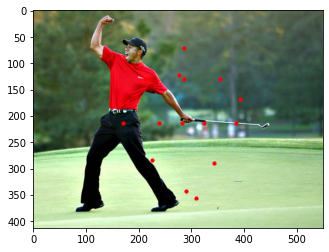

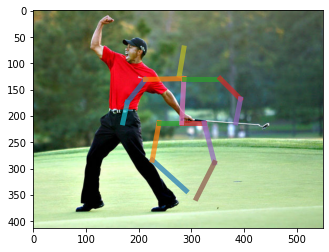

In [31]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

## 회고
- readonly file system문제 
    - models의 권한을 변경할수가 없어서 models1으로 새로 만들고 진행 하니 문제가 해결됨,
- heatmap 문제
     - 16으로 맞추니 해결됨.
- float32 int32 에러 
    - 에러의 원인은 대강 파악했으나 어디를 고쳐야 할지 알수가 없어서 해매다가 loss를 0 대신 0.0으로 바꾸니 해결됨.

- stacked hourglass : Epoch 5 val loss 1.1752301454544067 
- simplebaseline : Epoch 5 val loss 6.308299541473389